In [124]:
# ===================================================================
# IMPORTS
# ===================================================================
# Reload functions after changes
import importlib
import functions
importlib.reload(functions)
from functions import *


Libraries imported successfully
pymrio version: 0.5.4
Base path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit
EXIOBASE data path: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Exiobase3_ixi_latest
Results will be saved to: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\Results
Years for time series: 1995-2022
Loading population data from: C:\Users\Marine Riesterer\OneDrive\Desktop\MA Arbeit\code\producerappraoch\clean code\exiobase3_population_2022_official.csv
Population data shape: (49, 3)
Columns: ['EXIOBASE3_Code', 'Population_2022', 'Source']

First 5 rows:
  EXIOBASE3_Code  Population_2022             Source
0             AT       9041851.00  World Bank (2022)
1             BE      11680210.00  World Bank (2022)
2             BG       6643324.00  World Bank (2022)
3             CY       1331370.00  World Bank (2022)
4             CZ      10672118.00  World Bank (2022)
Defined 20 emission categories
Defined 8 total value-added components
  - 2 tax components
 

In [27]:

# ===================================================================
# LOAD DATA
# ===================================================================

# Load EXIOBASE for single year
ixi_data = load_exiobase_year(SINGLE_YEAR)



Loading EXIOBASE data for year 2019...
✓ Year 2019 loaded successfully
  Regions: 49
  Sectors: 163


In [28]:
# ===================================================================
# SECTOR MAPPING
# ===================================================================

# Get all sectors from EXIOBASE
all_sectors = ixi_data.get_sectors()
print(f"Total sectors in EXIOBASE: {len(all_sectors)}")

# Create DataFrame with sector mapping
df_sectors = pd.DataFrame({'sector': all_sectors})
df_sectors['category'] = df_sectors['sector'].apply(category_of)
df_sectors['colour'] = df_sectors['sector'].apply(colour_of)

print("\nSector distribution:")
print(df_sectors['category'].value_counts())

# Create analysis-specific sector lists
fossil_sectors = get_sectors_by_categories(["Coal", "Oil", "Gas"])
service_sectors = get_sectors_by_categories(["Services"])
Manufacturing_sectors = get_sectors_by_categories(["Manufacturing (Food & Beverages)", "Manufacturing (Textiles, Leather & Wood)", "Manufacturing (Machinery & Equipment)"])

print(f"\nFossil fuel sectors: {len(fossil_sectors)}")

print(f"Service sectors: {len(service_sectors)}")

print(f"Manufacturing sectors: {len(Manufacturing_sectors)}")

Total sectors in EXIOBASE: 163

Sector distribution:
Waste & Recycling                           35
Services                                    19
Agriculture                                 17
Metals                                      15
Manufacturing (Food & Beverages)            12
Non-metallic Minerals                        9
Manufacturing (Machinery & Equipment)        8
Chemicals & Plastics                         7
Energy & Utilities Infrastructure            7
Renewables                                   7
Transport                                    7
Gas                                          5
Manufacturing (Textiles, Leather & Wood)     5
Oil                                          4
Coal                                         3
Construction & Trade                         3
Name: category, dtype: int64

Fossil fuel sectors: 12
Service sectors: 23
Manufacturing sectors: 25


In [125]:
# ===================================================================
# CALCULATE CLEAN VA COEFFICIENTS
# ===================================================================

# All components
v_clean_all, v_raw_all = calculate_clean_va_coefficients(
    ixi_data, VALUE_ADDED_COMPONENTS
)

# Profit only
v_clean_profit, v_raw_profit = calculate_clean_va_coefficients(
    ixi_data, PROFIT_COMPONENTS
)

# Without taxes
components_no_tax = [c for c in VALUE_ADDED_COMPONENTS if c not in TAX_COMPONENTS]
v_clean_no_tax, v_raw_no_tax = calculate_clean_va_coefficients(
    ixi_data, components_no_tax
)

# ===================================================================
# RUN RESPONSIBILITY CALCULATIONS
# ===================================================================

print("\n" + "="*70)
print("CALCULATING ALL RESPONSIBILITY METHODS")
print("="*70)

# Producer responsibility
producer_emissions, missing = calculate_producer_responsibility(
    ixi_data, EMISSION_CATEGORIES
)

# Consumer responsibility
consumer_by_country, consumer_details = calculate_consumer_responsibility(
    ixi_data, producer_emissions
)

# VABR - all components
vabr_all, vabr_all_details, consumer_baseline = calculate_vabr(
    ixi_data, producer_emissions, v_clean_all
)

# VABR - profit only
vabr_profit, vabr_profit_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_profit
)

# VABR - no taxes
vabr_no_tax, vabr_no_tax_details, _ = calculate_vabr(
    ixi_data, producer_emissions, v_clean_no_tax
)
## Technology-adjusted VABR calculations
vabr_techA, vabr_techA_details, consumer_tcba = calculate_vabr_tech_adjusted(
    ixi_data=ixi_data,
    producer_emissions=producer_emissions,
    v_clean=v_clean_all,
    conserve_global=True
)


## Bottom-up supply drived responsibility calculation
# (producer-centric profit-based responsibility calculation)
pcpr_totals, pcpr_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=PROFIT_COMPONENTS,
    method='inverse'
)

print("\n" + "="*70)
print("ALL CALCULATIONS COMPLETE")
print("="*70)


Calculating VA coefficients using 8 components...
  Set 0 negative VA values to 0
  Capped 37 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=1.6301
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 4 components...
  Set 0 negative VA values to 0
  Capped 15 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=36.3956
  AFTER cleaning:  Min=0.0000, Max=1.0000
Calculating VA coefficients using 7 components...
  Set 0 negative VA values to 0
  Capped 59 coefficients > 1
  BEFORE cleaning: Min=0.0000, Max=37.3111
  AFTER cleaning:  Min=0.0000, Max=1.0000

CALCULATING ALL RESPONSIBILITY METHODS
Total producer emissions: 44.715 Gt CO2-eq
Total consumer emissions: 44.712 Gt CO2-eq

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION ===
Return allocation details: False
Total consumer emissions: 44.712 Gt
Total VABR: 44.712 Gt, Error: 0.0000%

=== VABR CALCULATION

ANALYSIS


=== Aggregating producer emissions by country ===
Total producer emissions: 44.715 Gt

=== Calculating PCPR with all VA components ===

=== PRODUCER-CENTRIC PROFIT-BASED RESPONSIBILITY (INVERSE) ===
Sectors: 7987, Regions: 49
Total emissions: 44.715 Gt CO2-eq
Floored sectors: 4479 (56.1%)
S row sums: mean=0.525, max=1.000
Total profit VA: 0.1 B€
Profit coefficients: mean=0.205
Computing D = (I - S)^(-1)...
  Condition number: 1.25e+01
FD flows: direct=0.200, total=0.515 (ratio: 2.57x)
Per-producer allocation...
  Producers processed: 6947
  Zero profit capture: 470
Conservation: 44.7154 Gt (error: 0.000000%)

Top 5 countries:
  CN: 12.955 Gt (1.00x)
  US: 5.298 Gt (1.04x)
  IN: 3.378 Gt (0.98x)
  WA: 3.337 Gt (0.95x)
  WM: 2.710 Gt (0.89x)

ANALYSIS 1: Top Emitters - Comparison of All Methods (2019)

Comparison DataFrame shape: (49, 6)
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']

TOP 10 EMITTERS BY METHOD (Gt CO2-eq)

PRODUCER:

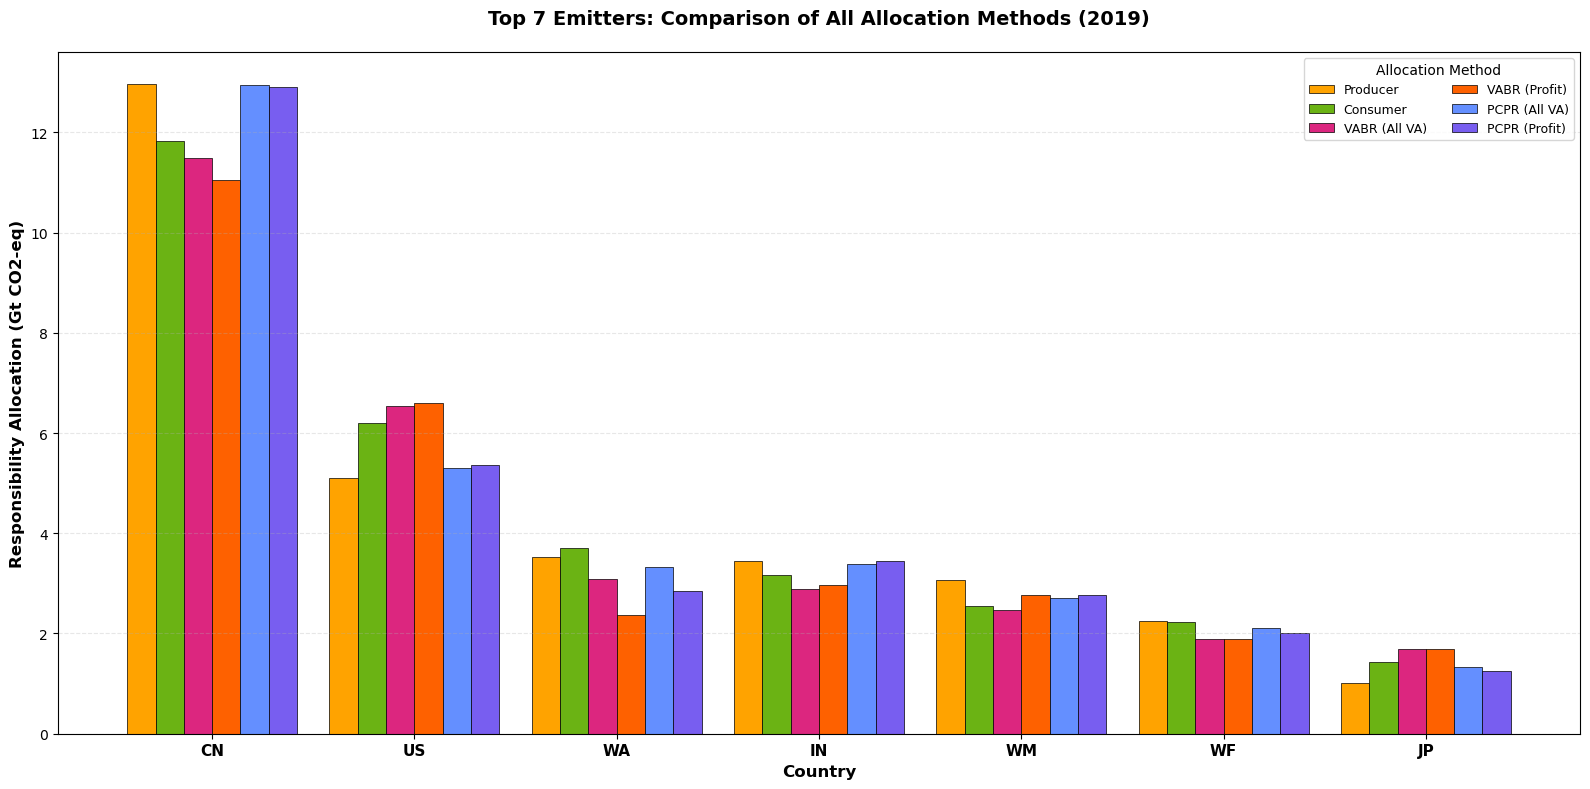


✓ Top 7 emitters bar chart created (6 methods)

### Summary Statistics ###
Top 7 represent:
  Producer            : 31.34 Gt (70.1% of global)
  Consumer            : 31.10 Gt (69.5% of global)
  VABR (All VA)       : 30.05 Gt (67.2% of global)
  VABR (Profit)       : 29.29 Gt (65.5% of global)
  PCPR (All VA)       : 31.11 Gt (69.6% of global)
  PCPR (Profit)       : 30.58 Gt (68.4% of global)

### Detailed Method Comparison (Top 7 Countries) ###

CN:
  Producer:        12.96 Gt (100%)
  Consumer:        11.82 Gt ( 91.2%)
  VABR (All VA):   11.49 Gt ( 88.7%)
  VABR (Profit):   11.04 Gt ( 85.2%)
  PCPR (All VA):   12.96 Gt (100.0%)
  PCPR (Profit):   12.91 Gt ( 99.6%)
  → Closest to Producer: PCPR (All VA) (diff: 0.01 Gt)

US:
  Producer:         5.10 Gt (100%)
  Consumer:         6.21 Gt (121.7%)
  VABR (All VA):    6.53 Gt (128.0%)
  VABR (Profit):    6.59 Gt (129.2%)
  PCPR (All VA):    5.30 Gt (103.9%)
  PCPR (Profit):    5.37 Gt (105.3%)
  → Closest to Producer: PCPR (All VA) (di

In [30]:
# ===================================================================
# AGGREGATE PRODUCER EMISSIONS BY COUNTRY
# ===================================================================
print("\n=== Aggregating producer emissions by country ===")

regions = ixi_data.get_regions()
producer_by_country = {}

for region in regions:
    region_mask = ixi_data.x.index.get_level_values(0) == region
    region_indices = np.where(region_mask)[0]
    producer_by_country[region] = producer_emissions[region_indices].sum()

producer_series = pd.Series(producer_by_country)
print(f"Total producer emissions: {producer_series.sum()/1e9:.3f} Gt")

# ===================================================================
# CALCULATE MISSING PCPR VARIANT (with all VA)
# ===================================================================
print("\n=== Calculating PCPR with all VA components ===")

pcpr_all_totals, pcpr_all_details = calculate_pcpr(
    ixi_data, 
    producer_emissions, 
    profit_components=VALUE_ADDED_COMPONENTS,  # All VA!
    method='inverse'
)

# ===================================================================
# ANALYSIS: TOP EMITTERS - ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 1: Top Emitters - Comparison of All Methods ({SINGLE_YEAR})")
print("="*70)

# Create comparison DataFrame with ALL 6 methods
comparison_df = pd.DataFrame({
    'Producer': producer_series / 1e9,
    'Consumer': consumer_by_country / 1e9,
    'VABR (All VA)': vabr_all / 1e9,
    'VABR (Profit)': vabr_profit / 1e9,
    'PCPR (All VA)': pcpr_all_totals / 1e9,
    'PCPR (Profit)': pcpr_totals / 1e9
})

print(f"\nComparison DataFrame shape: {comparison_df.shape}")
print(f"Methods: {list(comparison_df.columns)}")

# ===================================================================
# PRINT TOP 10 FOR EACH METHOD
# ===================================================================

print("\n" + "="*70)
print("TOP 10 EMITTERS BY METHOD (Gt CO2-eq)")
print("="*70)

for method in comparison_df.columns:
    print(f"\n{method.upper()}:")
    top10 = comparison_df[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} Gt")

# ===================================================================
# BAR PLOT: TOP 7 COUNTRIES
# ===================================================================

# Select top 7 countries by VABR (All VA)
top7_countries = comparison_df['VABR (All VA)'].nlargest(7).index.tolist()
plot_data = comparison_df.loc[top7_countries]

print(f"\nTop 7 countries for bar plot: {top7_countries}")

# Create plot
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_data.columns)
x = np.arange(len(top7_countries))
width = 0.14

# Colors for all 6 methods (UPDATED NAMES)
colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
    'PCPR (All VA)': '#648fff',      # Changed from Bottom-Up
    'PCPR (Profit)': '#785ef0'       # Changed from Bottom-Up
}

for i, method in enumerate(plot_data.columns):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors[method],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(f'Top 7 Emitters: Comparison of All Allocation Methods ({SINGLE_YEAR})',
             fontsize=14, fontweight='bold', pad=20)
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top7_countries, fontsize=11, fontweight='bold')
ax.legend(title="Allocation Method", fontsize=9, title_fontsize=10, 
          loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Top 7 emitters bar chart created (6 methods)")

# ===================================================================
# SUMMARY STATISTICS
# ===================================================================

print("\n### Summary Statistics ###")
print(f"Top 7 represent:")
for method in comparison_df.columns:
    top7_sum = plot_data[method].sum()
    total = comparison_df[method].sum()
    percentage = (top7_sum / total) * 100
    print(f"  {method:20s}: {top7_sum:5.2f} Gt ({percentage:4.1f}% of global)")

# ===================================================================
# METHOD COMPARISON BY COUNTRY
# ===================================================================

print("\n### Detailed Method Comparison (Top 7 Countries) ###")

for country in top7_countries:
    producer = comparison_df.loc[country, 'Producer']
    consumer = comparison_df.loc[country, 'Consumer']
    vabr_all = comparison_df.loc[country, 'VABR (All VA)']
    vabr_profit = comparison_df.loc[country, 'VABR (Profit)']
    pcpr_all = comparison_df.loc[country, 'PCPR (All VA)']
    pcpr_profit = comparison_df.loc[country, 'PCPR (Profit)']
    
    print(f"\n{country}:")
    print(f"  Producer:        {producer:5.2f} Gt (100%)")
    print(f"  Consumer:        {consumer:5.2f} Gt ({consumer/producer*100:5.1f}%)")
    print(f"  VABR (All VA):   {vabr_all:5.2f} Gt ({vabr_all/producer*100:5.1f}%)")
    print(f"  VABR (Profit):   {vabr_profit:5.2f} Gt ({vabr_profit/producer*100:5.1f}%)")
    print(f"  PCPR (All VA):   {pcpr_all:5.2f} Gt ({pcpr_all/producer*100:5.1f}%)")
    print(f"  PCPR (Profit):   {pcpr_profit:5.2f} Gt ({pcpr_profit/producer*100:5.1f}%)")
    
    # Find which method is closest to Producer
    methods_dict = {
        'Consumer': consumer,
        'VABR (All VA)': vabr_all,
        'VABR (Profit)': vabr_profit,
        'PCPR (All VA)': pcpr_all,
        'PCPR (Profit)': pcpr_profit
    }
    
    closest = min(methods_dict.items(), key=lambda x: abs(x[1] - producer))
    print(f"  → Closest to Producer: {closest[0]} (diff: {abs(closest[1] - producer):.2f} Gt)")

# ===================================================================
# CORRELATION ANALYSIS
# ===================================================================

print("\n### Correlation Matrix (All Countries) ###")
corr_matrix = comparison_df.corr().round(3)
print(corr_matrix)

# ===================================================================
# KEY PATTERNS
# ===================================================================

print("\n### Key Patterns Across Methods ###")

# Compare VABR vs PCPR
print("\nVABR (All VA) vs PCPR (All VA):")
print("Countries where PCPR allocates LESS than VABR:")
diff_vabr_pcpr = comparison_df['VABR (All VA)'] - comparison_df['PCPR (All VA)']
biggest_diff = diff_vabr_pcpr.nlargest(10)
for country, diff in biggest_diff.items():
    vabr_val = comparison_df.loc[country, 'VABR (All VA)']
    pcpr_val = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: VABR {vabr_val:.2f} → PCPR {pcpr_val:.2f} (diff: {diff:.2f} Gt)")

print("\nCountries where PCPR allocates MORE than VABR:")
smallest_diff = diff_vabr_pcpr.nsmallest(10)
for country, diff in smallest_diff.items():
    vabr_val = comparison_df.loc[country, 'VABR (All VA)']
    pcpr_val = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: VABR {vabr_val:.2f} → PCPR {pcpr_val:.2f} (diff: {diff:+.2f} Gt)")

# Effect of Profit-only
print("\n### Effect of Profit-Only Specification ###")

print("\nVABR: All VA vs Profit")
vabr_change = comparison_df['VABR (Profit)'] - comparison_df['VABR (All VA)']
print(f"Average change: {vabr_change.mean():+.3f} Gt")
print(f"Countries most affected (top 5):")
for country in vabr_change.abs().nlargest(5).index:
    change = vabr_change[country]
    print(f"  {country}: {change:+.2f} Gt")

print("\nPCPR: All VA vs Profit")
pcpr_change = comparison_df['PCPR (Profit)'] - comparison_df['PCPR (All VA)']
print(f"Average change: {pcpr_change.mean():+.3f} Gt")
print(f"Countries most affected (top 5):")
for country in pcpr_change.abs().nlargest(5).index:
    change = pcpr_change[country]
    print(f"  {country}: {change:+.2f} Gt")


ANALYSIS: Absolute Emissions (Top 10 + Rest of World) (2019)

Top 10 absolute emitters (by VABR (All VA)): ['CN', 'US', 'WA', 'IN', 'WM', 'WF', 'JP', 'RU', 'WL', 'DE']

Total emissions by method (all countries, Gt):
Producer        44.72
Consumer        44.71
VABR (All VA)   44.71
VABR (Profit)   44.71
dtype: float64

Rest of world (Gt CO2-eq) for each method:
Producer         9.37
Consumer         9.86
VABR (All VA)   10.68
VABR (Profit)   11.41
dtype: float64


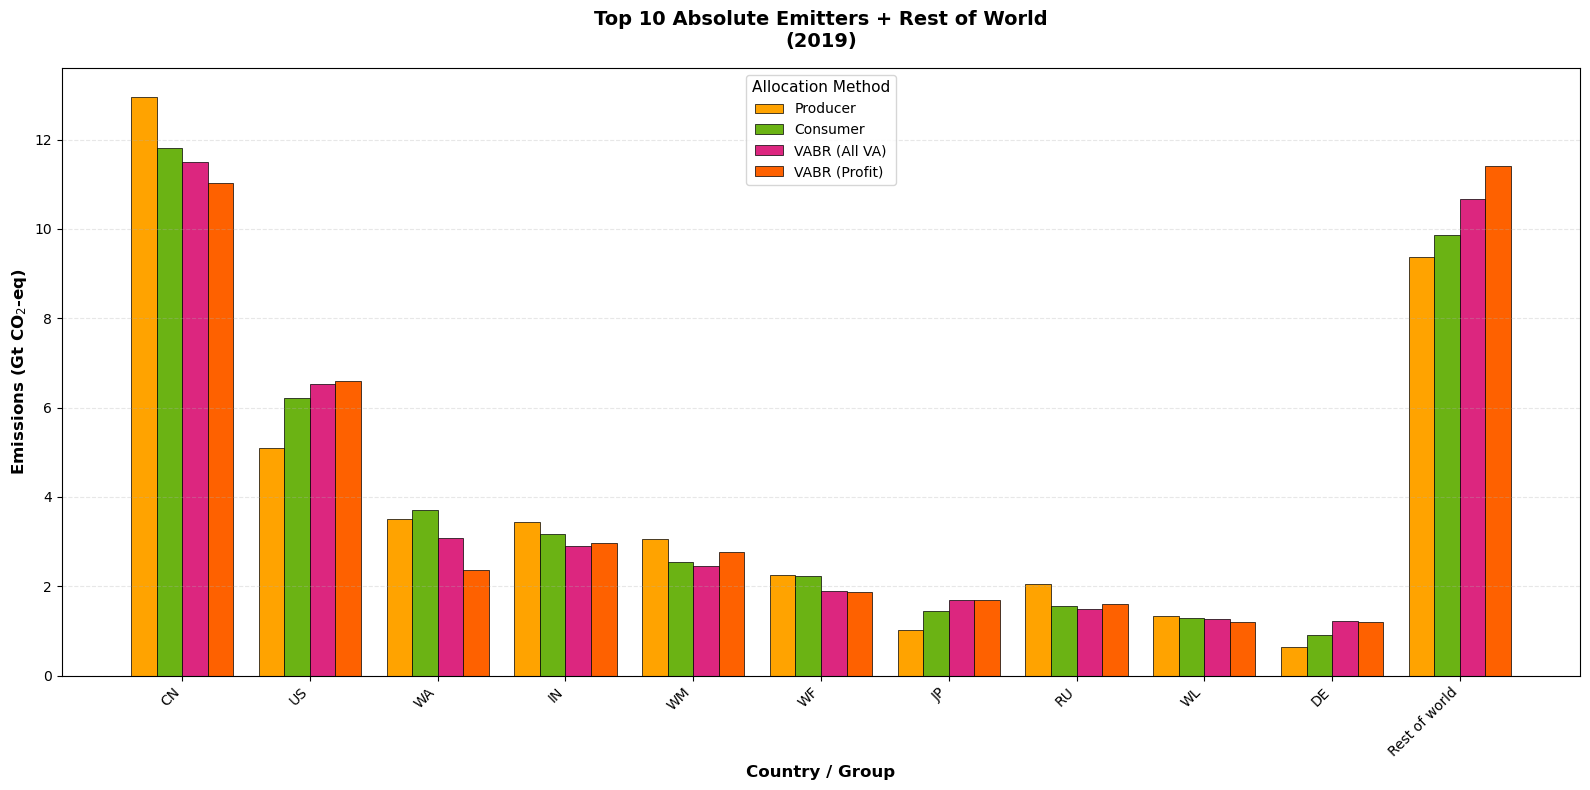


✓ Absolute emissions bar chart created (Top 10 + Rest of world, ohne PCPR)


In [31]:
# ===================================================================
# ABSOLUTE EMISSIONS BAR PLOT - Top 10 + Rest of World (ohne PCPR)
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Absolute Emissions (Top 10 + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# Methoden, die du vergleichen willst (PCPR explizit weggelassen)
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']

# Sicherheitscheck: existieren alle Spalten?
missing_methods = [m for m in plot_methods if m not in comparison_df.columns]
if missing_methods:
    raise KeyError(f"Fehlende Methoden in comparison_df: {missing_methods}")

# 1) Top 10 Länder nach VABR (All VA) in absoluten Emissionen (Gt)
#    (wenn du lieber nach Producer sortieren willst, nimm 'Producer' statt 'VABR (All VA)')
reference_method = 'VABR (All VA)'
top10_countries = comparison_df[reference_method].nlargest(10).index.tolist()
print(f"\nTop 10 absolute emitters (by {reference_method}): {top10_countries}")

# 2) "Rest of world" berechnen: Summe aller anderen Länder für jede Methode
rest_of_world = comparison_df.drop(index=top10_countries)[plot_methods].sum()

print("\nTotal emissions by method (all countries, Gt):")
print(comparison_df[plot_methods].sum().round(2))

print("\nRest of world (Gt CO2-eq) for each method:")
print(rest_of_world.round(2))

# 3) Plot-Daten vorbereiten: Top 10 + Rest of world
plot_data = comparison_df.loc[top10_countries, plot_methods].copy()
plot_data.loc['Rest of world'] = rest_of_world

# Reihenfolge sichern
countries_for_plot = top10_countries + ['Rest of world']
plot_data = plot_data.loc[countries_for_plot]

# 4) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_methods)
x = np.arange(len(countries_for_plot))
width = 0.8 / n_methods  # Gesamtbreite ~0.8 aufgeteilt auf Methoden

# Farben (angepasst ohne PCPR)
colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors.get(method, None),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top 10 Absolute Emitters + Rest of World\n({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (Gt CO$_2$-eq)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot, rotation=45, ha='right', fontsize=10)

ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Absolute emissions bar chart created (Top 10 + Rest of world, ohne PCPR)")


Columns in comparison_df: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)', 'VABR (Tech A)', 'VABR (Tech B)']

ANALYSIS: Absolute Emissions (Top 10 + Rest of World) (2019)

Top 10 absolute emitters (by VABR (All VA)): ['CN', 'US', 'WA', 'IN', 'WM', 'WF', 'JP', 'RU', 'WL', 'DE']

Total emissions by method (all countries, Gt):
Producer        44.72
Consumer        44.71
VABR (All VA)   44.71
VABR (Profit)   44.71
VABR (Tech A)   44.71
VABR (Tech B)   57.68
dtype: float64

Rest of world (Gt CO2-eq) for each method:
Producer         9.37
Consumer         9.86
VABR (All VA)   10.68
VABR (Profit)   11.41
VABR (Tech A)   11.85
VABR (Tech B)   13.56
dtype: float64


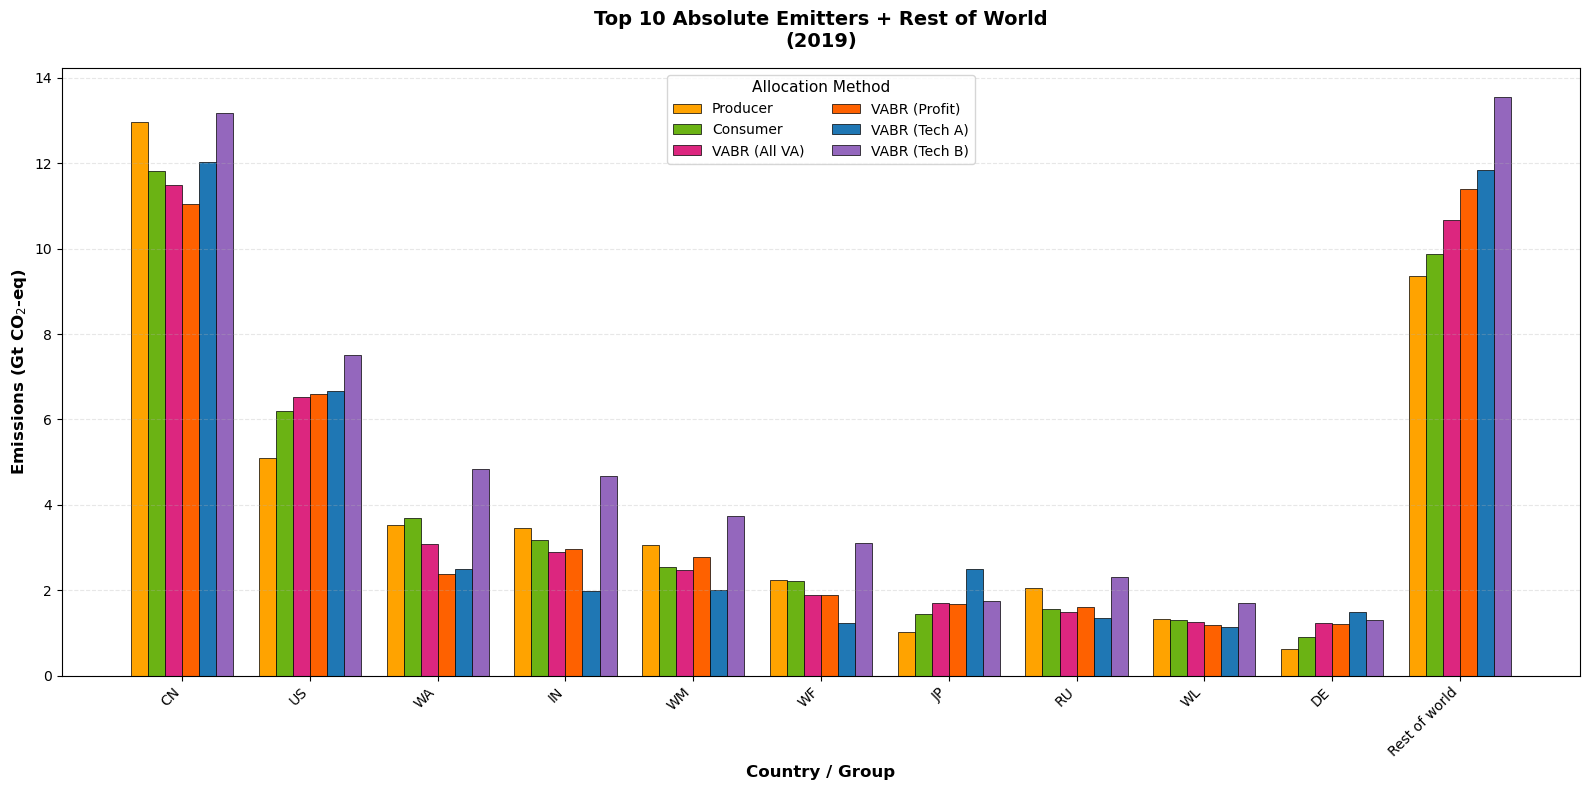


✓ Absolute emissions bar chart created (Top 10 + Rest of world, inkl. Tech A & B)


In [ ]:
# ===================================================================
# REBUILD comparison_df WITH ALL METHODS (IN Gt CO2-eq)
# ===================================================================
##issue hier ist dass tech ad option b nicht masse konserviert
comparison_df = pd.DataFrame(index=producer_series.index)

comparison_df["Producer"]        = producer_series / 1e9
comparison_df["Consumer"]        = consumer_by_country / 1e9
comparison_df["VABR (All VA)"]   = vabr_all / 1e9
comparison_df["VABR (Profit)"]   = vabr_profit / 1e9
comparison_df["PCPR (All VA)"]   = pcpr_all_totals / 1e9
comparison_df["PCPR (Profit)"]   = pcpr_totals / 1e9

# Tech-adjusted variants (A: Kander, B: VABR + tech penalty)
comparison_df["VABR (Tech A)"]   = vabr_techA.reindex(comparison_df.index) / 1e9
comparison_df["VABR (Tech B)"]   = resp_B.reindex(comparison_df.index) / 1e9

print("Columns in comparison_df:", list(comparison_df.columns))


# ===================================================================
# ABSOLUTE EMISSIONS BAR PLOT - Top 10 + Rest of World (inkl. Tech A & B)
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Absolute Emissions (Top 10 + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# Methods to compare (PCPR bewusst weggelassen)
plot_methods = [
    "Producer",
    "Consumer",
    "VABR (All VA)",
    "VABR (Profit)",
    "VABR (Tech A)",
    "VABR (Tech B)",
]

# Safety check
missing_methods = [m for m in plot_methods if m not in comparison_df.columns]
if missing_methods:
    raise KeyError(f"Fehlende Methoden in comparison_df: {missing_methods}")

# 1) Top 10 countries nach VABR (All VA)
reference_method = "VABR (All VA)"
top10_countries = comparison_df[reference_method].nlargest(10).index.tolist()
print(f"\nTop 10 absolute emitters (by {reference_method}): {top10_countries}")

# 2) Rest of world
rest_of_world = comparison_df.drop(index=top10_countries)[plot_methods].sum()

print("\nTotal emissions by method (all countries, Gt):")
print(comparison_df[plot_methods].sum().round(2))

print("\nRest of world (Gt CO2-eq) for each method:")
print(rest_of_world.round(2))

# 3) Plot data: Top 10 + RoW
plot_data = comparison_df.loc[top10_countries, plot_methods].copy()
plot_data.loc["Rest of world"] = rest_of_world

countries_for_plot = top10_countries + ["Rest of world"]
plot_data = plot_data.loc[countries_for_plot]

# 4) Bar plot
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_methods)
x = np.arange(len(countries_for_plot))
width = 0.8 / n_methods

colors = {
    "Producer":        "#ffa300",
    "Consumer":        "#6bb314",
    "VABR (All VA)":   "#dc267f",
    "VABR (Profit)":   "#fe6100",
    "VABR (Tech A)":   "#1f77b4",  # you can adjust colors
    "VABR (Tech B)":   "#9467bd",
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors.get(method, None),
        edgecolor="black",
        linewidth=0.5,
    )

ax.set_title(
    f"Top 10 Absolute Emitters + Rest of World\n({SINGLE_YEAR})",
    fontsize=14,
    fontweight="bold",
    pad=15,
)
ax.set_ylabel("Emissions (Gt CO$_2$-eq)", fontsize=12, fontweight="bold")
ax.set_xlabel("Country / Group", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot, rotation=45, ha="right", fontsize=10)

ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11, ncol=2)
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

print("\n✓ Absolute emissions bar chart created (Top 10 + Rest of world, inkl. Tech A & B)")



ANALYSIS: Per Capita Emissions (Top 10 + Rest of World) (2019)

Countries with population data: 49/49
Per capita shape: (49, 4)

Top 10 per capita (by VABR (All VA)): ['LU', 'CH', 'IE', 'AU', 'US', 'NO', 'DK', 'KR', 'NL', 'FI']

Rest of world per capita (tonnes/person) for each method:
Producer        5.03
Consumer        4.85
VABR (All VA)   4.75
VABR (Profit)   4.71
Name: Rest of world, dtype: float64


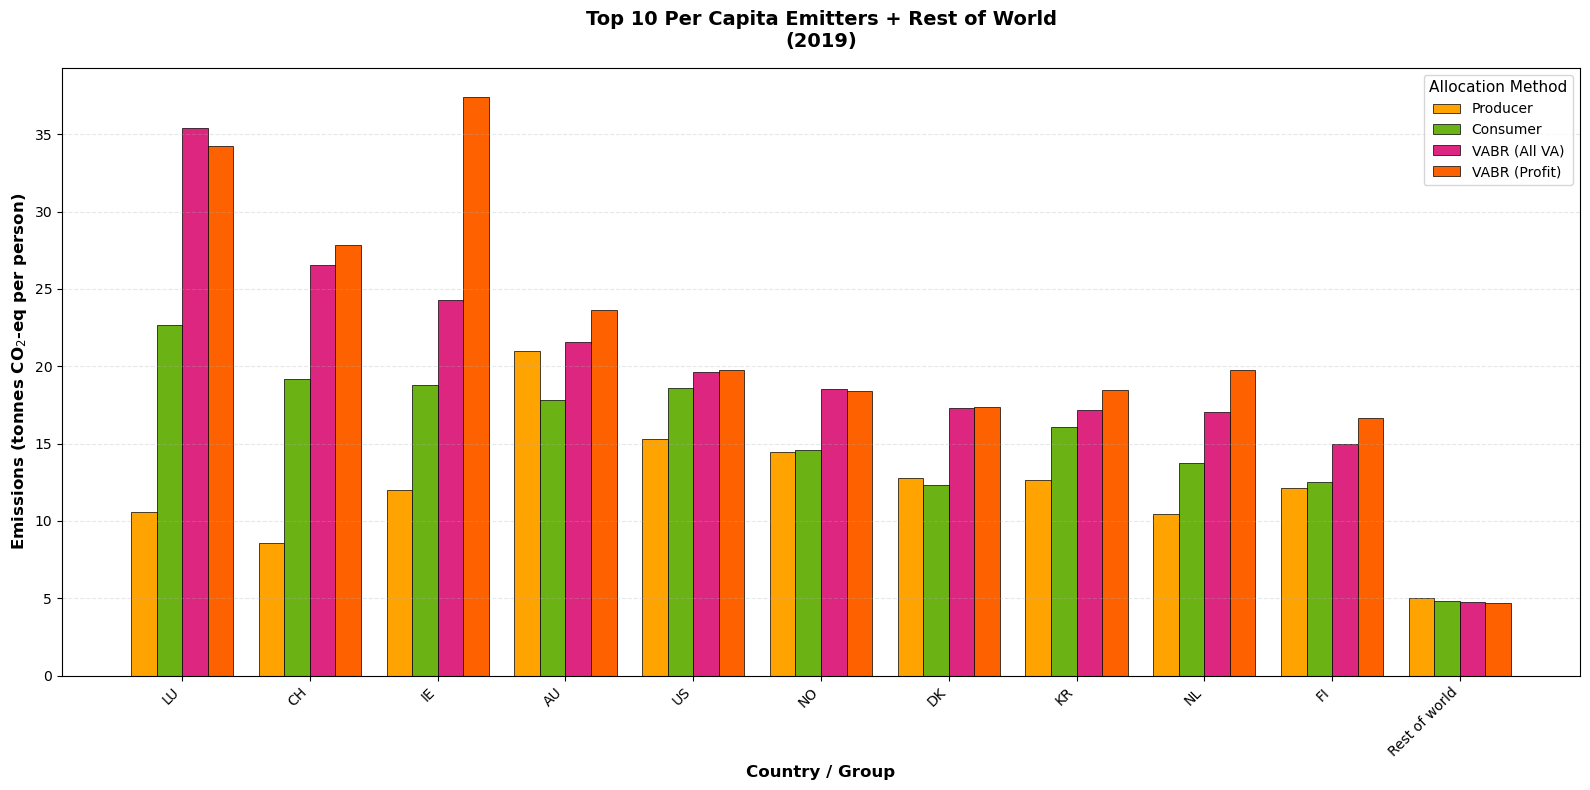


✓ Per capita bar chart created (Top 10 + Rest of world)


In [32]:
# ===================================================================
# PER CAPITA EMISSIONS BAR PLOT - Top 10 + Rest of World
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS: Per Capita Emissions (Top 10 + Rest of World) ({SINGLE_YEAR})")
print("="*70)

# Methoden, die du vergleichen willst (ohne PCPR)
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']

# 1) Länder, für die sowohl Emissionen als auch Bevölkerung vorhanden sind
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# 2) Per capita DataFrame bauen (tonnes CO2-eq pro Person)
#    comparison_df ist in Gt -> * 1e9 = tonnes
per_capita = pd.DataFrame(index=common_countries)

for method in plot_methods:
    per_capita[method] = (
        comparison_df.loc[common_countries, method] * 1e9
        / population_2022.loc[common_countries]
    )

print(f"Per capita shape: {per_capita.shape}")

# 3) Top 10 Länder nach VABR (All VA) per capita auswählen
reference_method = 'VABR (All VA)'
top10_countries_pc = per_capita[reference_method].nlargest(10).index.tolist()
print(f"\nTop 10 per capita (by {reference_method}): {top10_countries_pc}")

# 4) "Rest of world" per capita berechnen:
#    -> aggregierte Emissionen der restlichen Länder / aggregierte Bevölkerung der restlichen Länder
rest_countries = common_countries.difference(top10_countries_pc)

rest_per_capita = {}
for method in plot_methods:
    # Emissionen restliche Länder (Gt -> tonnes)
    total_emissions_rest_tonnes = comparison_df.loc[rest_countries, method].sum() * 1e9
    # Bevölkerung restliche Länder
    total_pop_rest = population_2022.loc[rest_countries].sum()
    
    if total_pop_rest > 0:
        rest_per_capita[method] = total_emissions_rest_tonnes / total_pop_rest
    else:
        rest_per_capita[method] = np.nan

rest_per_capita = pd.Series(rest_per_capita, name='Rest of world')

print("\nRest of world per capita (tonnes/person) for each method:")
print(rest_per_capita.round(2))

# 5) Plot-Daten vorbereiten: Top 10 + Rest of world
plot_data_pc = per_capita.loc[top10_countries_pc, plot_methods].copy()
plot_data_pc.loc['Rest of world'] = rest_per_capita

countries_for_plot_pc = top10_countries_pc + ['Rest of world']
plot_data_pc = plot_data_pc.loc[countries_for_plot_pc]

# 6) Balkendiagramm
fig, ax = plt.subplots(figsize=(16, 8))

n_methods = len(plot_methods)
x = np.arange(len(countries_for_plot_pc))
width = 0.8 / n_methods  # Breite pro Methode

colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100',
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data_pc[method].values,
        width,
        label=method,
        color=colors.get(method, None),
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(
    f'Top 10 Per Capita Emitters + Rest of World\n({SINGLE_YEAR})',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Emissions (tonnes CO$_2$-eq per person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country / Group', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(countries_for_plot_pc, rotation=45, ha='right', fontsize=10)

ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created (Top 10 + Rest of world)")



SLOPE CHART: Country Rankings Across Methods

Countries shown: 18
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']


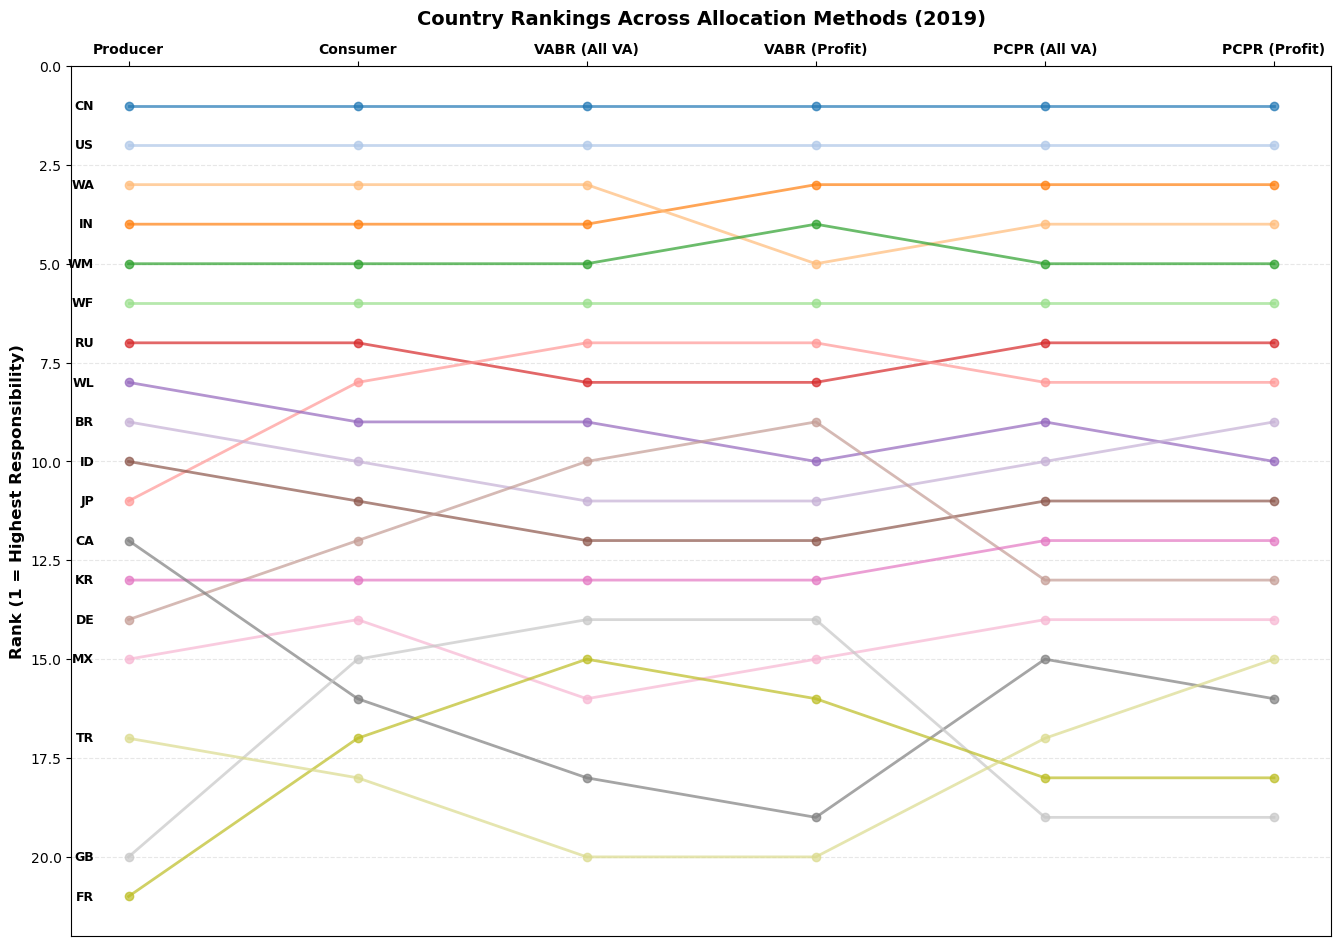


✓ Slope chart created

### Biggest Rank Changes ###

Producer → Consumer:
  Biggest rank improvements:
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    JP: #11 → #8 (-3)
  Biggest rank declines:
    CA: #12 → #16 (+4)
    WL: #8 → #9 (+1)
    BR: #9 → #10 (+1)

Consumer → VABR (All VA):
  Biggest rank improvements:
    DE: #12 → #10 (-2)
    FR: #17 → #15 (-2)
    JP: #8 → #7 (-1)
  Biggest rank declines:
    MX: #14 → #16 (+2)
    CA: #16 → #18 (+2)
    TR: #18 → #20 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    IN: #4 → #3 (-1)
    WM: #5 → #4 (-1)
    DE: #10 → #9 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19 (+1)

VABR (Profit) → PCPR (All VA):
  Biggest rank improvements:
    CA: #19 → #15 (-4)
    TR: #20 → #17 (-3)
    WA: #5 → #4 (-1)
  Biggest rank declines:
    GB: #14 → #19 (+5)
    DE: #9 → #13 (+4)
    FR: #16 → #18 (+2)

PCPR (All VA) → PCPR (Profit):
  Biggest rank improvements:
    TR: #17 → #15 (-2)

In [6]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

# Keep top 15 countries (appear in top 15 in any method)
top_countries = pd.Index(
    np.unique(
        np.concatenate([ranks[col].nsmallest(15).index for col in ranks.columns])
    )
)

# Filter to those countries only
ranks_filtered = ranks.loc[top_countries]

# Sort by average rank for better visualization
avg_rank = ranks_filtered.mean(axis=1).sort_values()
ranks_filtered = ranks_filtered.loc[avg_rank.index]

print(f"\nCountries shown: {len(ranks_filtered)}")
print(f"Methods: {list(ranks_filtered.columns)}")

# Define x positions
approaches = ranks_filtered.columns.tolist()
x = np.arange(len(approaches))

# Plot
fig, ax = plt.subplots(figsize=(14, 10))

# Color palette
colors = plt.cm.tab20.colors

for i, country in enumerate(ranks_filtered.index):
    # Plot line
    ax.plot(x, ranks_filtered.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=2,
            markersize=6,
            alpha=0.7)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_filtered.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=9,
            fontweight='bold')

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=10, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.invert_yaxis()  # Rank 1 at top

# Title below x-axis labels
ax.set_title(f"Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.3, linestyle='--', axis='y')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.08, right=0.98, top=0.92, bottom=0.05)

plt.show()

print("\n✓ Slope chart created")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_filtered[curr_method] - ranks_filtered[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(3)
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(3)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_filtered.loc[country, prev_method]
            new_rank = ranks_filtered.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_filtered.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(5).index:
    mean_rank = ranks_filtered.loc[country].mean()
    std_rank = ranks_filtered.loc[country].std()
    min_rank = ranks_filtered.loc[country].min()
    max_rank = ranks_filtered.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# ===================================================================
# COMPARE PRODUCER VS PCPR
# ===================================================================

print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_filtered['Producer']
pcpr_all_ranks = ranks_filtered['PCPR (All VA)']  # ✅ Fixed name
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(5).items():
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} ({int(diff):+d})")

# ===================================================================
# ADDITIONAL INSIGHT: VABR VS PCPR
# ===================================================================

print("\n### VABR vs PCPR Comparison ###")
vabr_ranks = ranks_filtered['VABR (All VA)']
pcpr_ranks = ranks_filtered['PCPR (All VA)']
vabr_pcpr_diff = pcpr_ranks - vabr_ranks

print("\nCountries that rank BETTER under PCPR than VABR:")
better_pcpr = vabr_pcpr_diff[vabr_pcpr_diff < 0].sort_values()
for country, diff in better_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")

print("\nCountries that rank WORSE under PCPR than VABR:")
worse_pcpr = vabr_pcpr_diff[vabr_pcpr_diff > 0].sort_values(ascending=False)
for country, diff in worse_pcpr.head(5).items():
    print(f"  {country}: VABR #{int(vabr_ranks[country])} → PCPR #{int(pcpr_ranks[country])} ({int(diff):+d})")


SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)

Total countries/regions: 49
Methods: ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)', 'PCPR (All VA)', 'PCPR (Profit)']


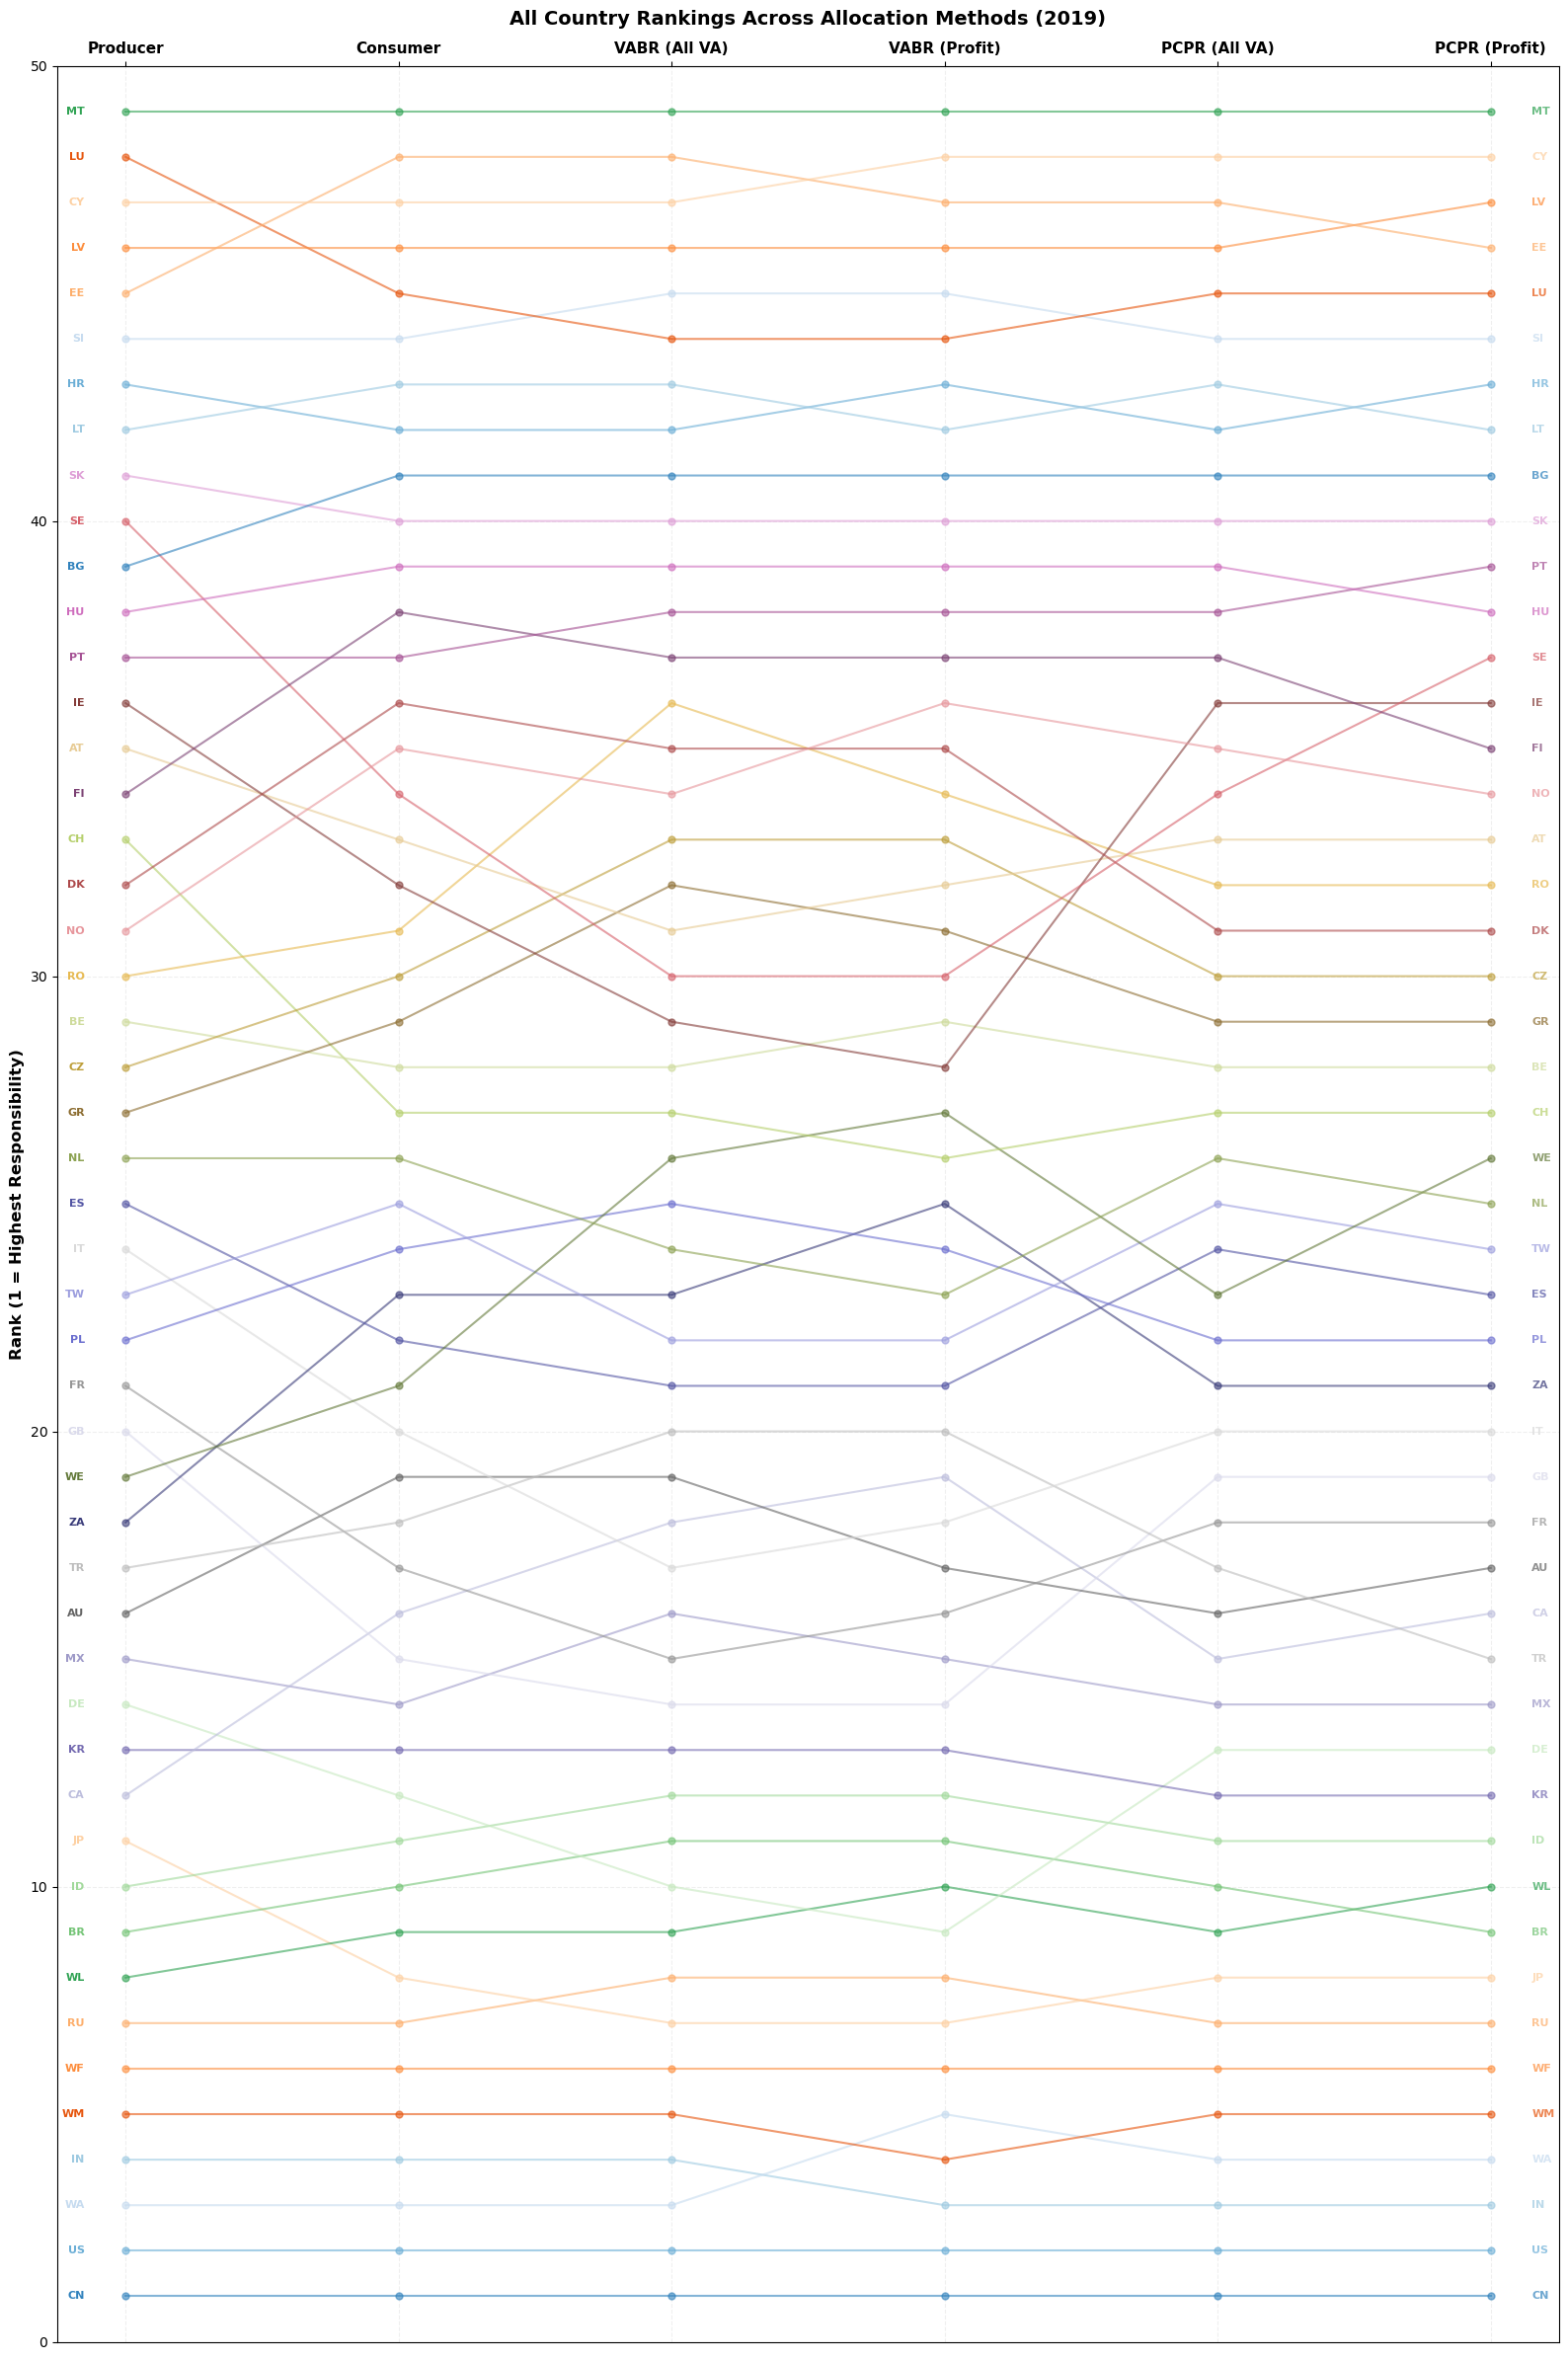


✓ Slope chart created (all regions)

### Biggest Rank Changes (All Regions) ###

Producer → Consumer:
  Biggest rank improvements:
    CH: #33 → #27 (-6)
    SE: #40 → #34 (-6)
    GB: #20 → #15 (-5)
    FR: #21 → #17 (-4)
    IT: #24 → #20 (-4)
  Biggest rank declines:
    ZA: #18 → #23 (+5)
    CA: #12 → #16 (+4)
    DK: #32 → #36 (+4)
    NO: #31 → #35 (+4)
    FI: #34 → #38 (+4)

Consumer → VABR (All VA):
  Biggest rank improvements:
    SE: #34 → #30 (-4)
    IT: #20 → #17 (-3)
    TW: #25 → #22 (-3)
    IE: #32 → #29 (-3)
    DE: #12 → #10 (-2)
  Biggest rank declines:
    WE: #21 → #26 (+5)
    RO: #31 → #36 (+5)
    GR: #29 → #32 (+3)
    CZ: #30 → #33 (+3)
    MX: #14 → #16 (+2)

VABR (All VA) → VABR (Profit):
  Biggest rank improvements:
    AU: #19 → #17 (-2)
    RO: #36 → #34 (-2)
    IN: #4 → #3 (-1)
    WM: #5 → #4 (-1)
    DE: #10 → #9 (-1)
  Biggest rank declines:
    WA: #3 → #5 (+2)
    ZA: #23 → #25 (+2)
    NO: #34 → #36 (+2)
    WL: #9 → #10 (+1)
    CA: #18 → #19

In [7]:
# ===================================================================
# SLOPE CHART: RANK CHANGES ACROSS ALL ALLOCATION METHODS
# ===================================================================

print("\n" + "="*70)
print("SLOPE CHART: Country Rankings Across Methods (ALL REGIONS)")
print("="*70)

# Compute ranks (1 = highest emitter)
ranks = comparison_df.rank(ascending=False, method='min')

print(f"\nTotal countries/regions: {len(ranks)}")
print(f"Methods: {list(ranks.columns)}")

# Sort by average rank for better visualization
avg_rank = ranks.mean(axis=1).sort_values()
ranks_sorted = ranks.loc[avg_rank.index]

# Define x positions
approaches = ranks_sorted.columns.tolist()
x = np.arange(len(approaches))

# Plot - MUCH BIGGER for all countries
fig, ax = plt.subplots(figsize=(16, 24))  # Tall figure for all countries

# Color palette - cycle through colors
colors = plt.cm.tab20c.colors + plt.cm.tab20b.colors  # 40 colors

for i, country in enumerate(ranks_sorted.index):
    # Plot line
    ax.plot(x, ranks_sorted.loc[country], 
            marker='o', 
            color=colors[i % len(colors)],
            linewidth=1.5,
            markersize=5,
            alpha=0.6)
    
    # Add country label on the LEFT (at first method)
    ax.text(x[0] - 0.15, ranks_sorted.loc[country, approaches[0]],
            country, 
            ha='right',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)])
    
    # OPTIONAL: Also add label on the RIGHT (at last method) for easier reading
    ax.text(x[-1] + 0.15, ranks_sorted.loc[country, approaches[-1]],
            country, 
            ha='left',
            va='center', 
            fontsize=8,
            fontweight='bold',
            color=colors[i % len(colors)],
            alpha=0.7)

# Set x-axis with method names on TOP
ax.set_xticks(x)
ax.set_xticklabels([])  # Remove bottom labels
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
ax.set_xticks(x)
ax.set_xticklabels(approaches, fontsize=11, fontweight='bold', rotation=0, ha='center')

# Y-axis
ax.set_ylabel("Rank (1 = Highest Responsibility)", fontsize=12, fontweight='bold')
ax.set_ylim(len(ranks) + 1, 0)  # Rank 1 at top, with some margin
ax.invert_yaxis()

# Title
ax.set_title(f"All Country Rankings Across Allocation Methods ({SINGLE_YEAR})", 
             fontsize=14, fontweight='bold', pad=30)

# Grid
ax.grid(alpha=0.2, linestyle='--', axis='both')

# Adjust layout to prevent label cutoff
plt.subplots_adjust(left=0.12, right=0.88, top=0.95, bottom=0.02)

plt.tight_layout()
plt.show()

print("\n✓ Slope chart created (all regions)")

# ===================================================================
# ANALYZE RANK CHANGES
# ===================================================================

print("\n### Biggest Rank Changes (All Regions) ###")

for method_idx in range(1, len(approaches)):
    prev_method = approaches[method_idx - 1]
    curr_method = approaches[method_idx]
    
    rank_change = ranks_sorted[curr_method] - ranks_sorted[prev_method]
    
    print(f"\n{prev_method} → {curr_method}:")
    
    # Biggest improvements (rank goes DOWN = better)
    improvers = rank_change.nsmallest(5)  # Show top 5
    if len(improvers) > 0:
        print("  Biggest rank improvements:")
        for country, change in improvers.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")
    
    # Biggest declines (rank goes UP = worse)
    decliners = rank_change.nlargest(5)
    if len(decliners) > 0:
        print("  Biggest rank declines:")
        for country, change in decliners.items():
            old_rank = ranks_sorted.loc[country, prev_method]
            new_rank = ranks_sorted.loc[country, curr_method]
            print(f"    {country}: #{int(old_rank)} → #{int(new_rank)} ({int(change):+d})")

# ===================================================================
# KEY INSIGHTS
# ===================================================================

print("\n### Key Insights (All Regions) ###")

# Most stable countries (low variance in ranks)
rank_variance = ranks_sorted.var(axis=1).sort_values()
print("\nMost stable rankings (consistent across methods):")
for country in rank_variance.head(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    print(f"  {country}: avg rank {mean_rank:.1f} (±{std_rank:.1f})")

# Most volatile countries (high variance in ranks)
print("\nMost volatile rankings (vary greatly by method):")
for country in rank_variance.tail(10).index:
    mean_rank = ranks_sorted.loc[country].mean()
    std_rank = ranks_sorted.loc[country].std()
    min_rank = ranks_sorted.loc[country].min()
    max_rank = ranks_sorted.loc[country].max()
    print(f"  {country}: avg {mean_rank:.1f} (±{std_rank:.1f}), range #{int(min_rank)}-#{int(max_rank)}")

# Compare traditional methods vs PCPR
print("\n### Producer vs PCPR Comparison ###")
producer_ranks = ranks_sorted['Producer']
pcpr_all_ranks = ranks_sorted['PCPR (All VA)']  # ✅ FIXED NAME
rank_diff = pcpr_all_ranks - producer_ranks

print("\nCountries that rank BETTER under PCPR:")
better = rank_diff[rank_diff < 0].sort_values()
for country, diff in better.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

print("\nCountries that rank WORSE under PCPR:")
worse = rank_diff[rank_diff > 0].sort_values(ascending=False)
for country, diff in worse.head(10).items():  # Top 10
    old_emissions = comparison_df.loc[country, 'Producer']
    new_emissions = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: #{int(producer_ranks[country])} → #{int(pcpr_all_ranks[country])} "
          f"({int(diff):+d}) | {old_emissions:.2f} → {new_emissions:.2f} Gt")

# ===================================================================
# ADDITIONAL: Countries with extreme changes
# ===================================================================

print("\n### Extreme Multipliers (PCPR vs Producer) ###")

multipliers = comparison_df['PCPR (All VA)'] / comparison_df['Producer']
multipliers = multipliers.replace([np.inf, -np.inf], np.nan).dropna()

print("\nHighest PCPR multipliers (most increased responsibility):")
for country in multipliers.nlargest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")

print("\nLowest PCPR multipliers (most decreased responsibility):")
for country in multipliers.nsmallest(10).index:
    mult = multipliers[country]
    prod = comparison_df.loc[country, 'Producer']
    pcpr = comparison_df.loc[country, 'PCPR (All VA)']
    print(f"  {country}: {mult:.2f}x ({prod:.3f} → {pcpr:.3f} Gt)")


ANALYSIS 2: Per Capita Emissions (2019)

Countries with population data: 49/49
Per capita shape: (49, 6)

TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)

PRODUCER:
 1. AU:  20.98 tonnes/person
 2. CA:  17.18 tonnes/person
 3. US:  15.30 tonnes/person
 4. NO:  14.43 tonnes/person
 5. RU:  14.17 tonnes/person
 6. GR:  13.03 tonnes/person
 7. TW:  12.87 tonnes/person
 8. DK:  12.77 tonnes/person
 9. KR:  12.67 tonnes/person
10. FI:  12.15 tonnes/person

CONSUMER:
 1. LU:  22.65 tonnes/person
 2. CH:  19.15 tonnes/person
 3. IE:  18.76 tonnes/person
 4. US:  18.62 tonnes/person
 5. AU:  17.79 tonnes/person
 6. KR:  16.08 tonnes/person
 7. NO:  14.59 tonnes/person
 8. CA:  14.02 tonnes/person
 9. NL:  13.72 tonnes/person
10. BE:  12.90 tonnes/person

VABR (ALL VA):
 1. LU:  36.19 tonnes/person
 2. IE:  26.70 tonnes/person
 3. CH:  26.30 tonnes/person
 4. AU:  21.64 tonnes/person
 5. US:  19.57 tonnes/person
 6. NO:  18.87 tonnes/person
 7. DK:  17.36 tonnes/person
 8. KR:  17.30 tonnes/

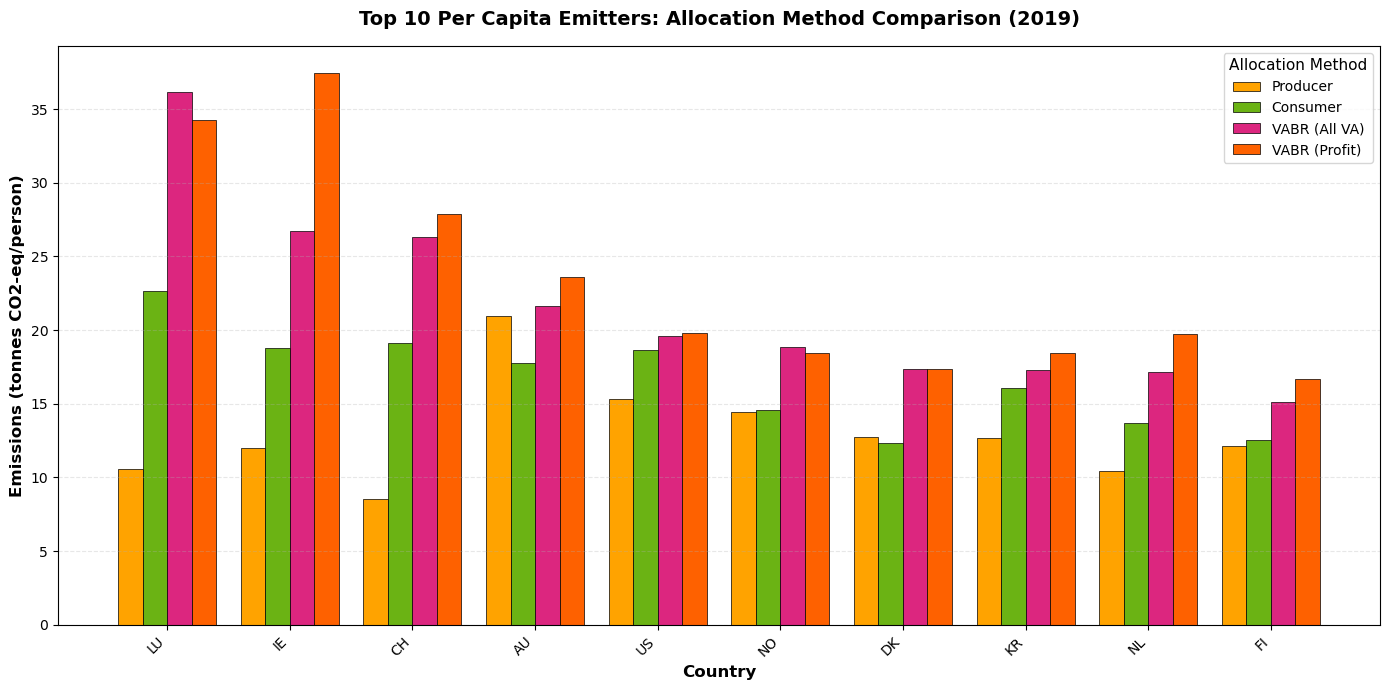


✓ Per capita bar chart created

### Per Capita Summary Statistics ###

Producer:
  Mean:   8.24 tonnes/person
  Median: 7.43 tonnes/person
  Max:    20.98 tonnes/person (AU)

Consumer:
  Mean:   9.60 tonnes/person
  Median: 8.41 tonnes/person
  Max:    22.65 tonnes/person (LU)

VABR (All VA):
  Mean:   11.11 tonnes/person
  Median: 9.97 tonnes/person
  Max:    36.19 tonnes/person (LU)

VABR (Profit):
  Mean:   11.65 tonnes/person
  Median: 10.13 tonnes/person
  Max:    37.42 tonnes/person (IE)

PCPR (All VA):
  Mean:   9.36 tonnes/person
  Median: 8.29 tonnes/person
  Max:    25.07 tonnes/person (LU)

PCPR (Profit):
  Mean:   9.68 tonnes/person
  Median: 8.67 tonnes/person
  Max:    24.42 tonnes/person (LU)

### Per Capita Inequality ###

Producer:
  Top 10 average:    14.55 tonnes/person
  Bottom 10 average: 3.99 tonnes/person
  Ratio (top/bottom): 3.6x

Consumer:
  Top 10 average:    16.83 tonnes/person
  Bottom 10 average: 4.00 tonnes/person
  Ratio (top/bottom): 4.2x

VABR (All VA

In [8]:
# ===================================================================
# ANALYSIS: PER CAPITA EMISSIONS
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 2: Per Capita Emissions ({SINGLE_YEAR})")
print("="*70)

# Use the comparison_df we already created!
# It has: Producer, Consumer, VABR (All VA), VABR (Profit), PCPR (All VA), PCPR (Profit)

# Align with population data (some countries might not have population)
common_countries = comparison_df.index.intersection(population_2022.index)
print(f"\nCountries with population data: {len(common_countries)}/{len(comparison_df)}")

# Create per capita DataFrame (comparison_df is already in Gt, so multiply by 1e9 to get tonnes)
per_capita = pd.DataFrame(index=common_countries)

for method in comparison_df.columns:
    # comparison_df is in Gt, population in persons
    # Gt * 1e9 = tonnes, divided by persons = tonnes/person
    per_capita[method] = (comparison_df.loc[common_countries, method] * 1e9) / population_2022.loc[common_countries]

print(f"Per capita shape: {per_capita.shape}")

# Display top 10 for each approach
print("\n" + "="*70)
print("TOP 10 PER CAPITA EMITTERS (tonnes CO2-eq/person)")
print("="*70)

for method in per_capita.columns:
    print(f"\n{method.upper()}:")
    top10 = per_capita[method].nlargest(10)
    for i, (country, emissions) in enumerate(top10.items(), 1):
        print(f"{i:2d}. {country}: {emissions:6.2f} tonnes/person")

# ===================================================================
# PER CAPITA BAR PLOT - Top 10
# ===================================================================

# Select top 10 countries by VABR (All VA) per capita for consistency
top10_per_capita = per_capita['VABR (All VA)'].nlargest(10).index.tolist()

print(f"\nTop 10 per capita countries: {top10_per_capita}")

# Plot data - select same methods as in absolute comparison
plot_methods = ['Producer', 'Consumer', 'VABR (All VA)', 'VABR (Profit)']
plot_data = per_capita.loc[top10_per_capita, plot_methods]

fig, ax = plt.subplots(figsize=(14, 7))

n_methods = len(plot_methods)
x = np.arange(len(top10_per_capita))
width = 0.2

colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR (All VA)': '#dc267f',
    'VABR (Profit)': '#fe6100'
}

for i, method in enumerate(plot_methods):
    ax.bar(
        x + i * width - (n_methods * width / 2) + (width / 2),
        plot_data[method].values,
        width,
        label=method,
        color=colors[method],
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title(f'Top 10 Per Capita Emitters: Allocation Method Comparison ({SINGLE_YEAR})', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Emissions (tonnes CO2-eq/person)', fontsize=12, fontweight='bold')
ax.set_xlabel('Country', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top10_per_capita, rotation=45, ha='right', fontsize=10)
ax.legend(title="Allocation Method", fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n✓ Per capita bar chart created")

# ===================================================================
# PER CAPITA SUMMARY STATISTICS
# ===================================================================

print("\n### Per Capita Summary Statistics ###")

for method in per_capita.columns:
    mean_val = per_capita[method].mean()
    median_val = per_capita[method].median()
    max_val = per_capita[method].max()
    max_country = per_capita[method].idxmax()
    
    print(f"\n{method}:")
    print(f"  Mean:   {mean_val:.2f} tonnes/person")
    print(f"  Median: {median_val:.2f} tonnes/person")
    print(f"  Max:    {max_val:.2f} tonnes/person ({max_country})")

# ===================================================================
# PER CAPITA INEQUALITY ANALYSIS
# ===================================================================

print("\n### Per Capita Inequality ###")

# Calculate ratios: highest vs lowest emitters
for method in per_capita.columns:
    sorted_vals = per_capita[method].sort_values(ascending=False)
    top10_mean = sorted_vals.head(10).mean()
    bottom10_mean = sorted_vals.tail(10).mean()
    ratio = top10_mean / bottom10_mean
    
    print(f"\n{method}:")
    print(f"  Top 10 average:    {top10_mean:.2f} tonnes/person")
    print(f"  Bottom 10 average: {bottom10_mean:.2f} tonnes/person")
    print(f"  Ratio (top/bottom): {ratio:.1f}x")

# ===================================================================
# COMPARE: Absolute vs Per Capita Rankings
# ===================================================================

print("\n### Absolute vs Per Capita Rankings ###")

# Countries that rank very differently
absolute_ranks = comparison_df['VABR (All VA)'].rank(ascending=False)
per_capita_ranks = per_capita['VABR (All VA)'].rank(ascending=False)

# Find countries in both rankings
common_for_rank = absolute_ranks.index.intersection(per_capita_ranks.index)
rank_diff = (per_capita_ranks.loc[common_for_rank] - 
             absolute_ranks.loc[common_for_rank])

print("\nCountries that rank MUCH HIGHER per capita (small countries with high emissions):")
for country in rank_diff.nsmallest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")

print("\nCountries that rank MUCH LOWER per capita (large countries with low per capita):")
for country in rank_diff.nlargest(10).index:
    abs_rank = int(absolute_ranks[country])
    pc_rank = int(per_capita_ranks[country])
    abs_val = comparison_df.loc[country, 'VABR (All VA)']
    pc_val = per_capita.loc[country, 'VABR (All VA)']
    print(f"  {country}: #{abs_rank} absolute → #{pc_rank} per capita "
          f"({abs_val:.2f} Gt vs {pc_val:.1f} t/person)")


RANKING TABLES: Country Rankings by Method

### ABSOLUTE EMISSIONS RANKING ###

Absolute Ranking Table (Top 20):
        Producer    Consumer VABR (All VA) VABR (Profit) PCPR (All VA)  \
Rank                                                                     
1     CN (12.96)  CN (11.82)    CN (11.46)    CN (11.04)    CN (12.91)   
2      US (5.10)   US (6.21)     US (6.52)     US (6.59)     US (5.29)   
3      WA (3.52)   WA (3.70)     WA (3.07)     IN (2.96)     IN (3.39)   
4      IN (3.45)   IN (3.17)     IN (2.90)     WM (2.77)     WA (3.32)   
5      WM (3.06)   WM (2.54)     WM (2.45)     WA (2.37)     WM (2.69)   
6      WF (2.24)   WF (2.22)     WF (1.88)     WF (1.88)     WF (2.10)   
7      RU (2.04)   RU (1.55)     JP (1.69)     JP (1.68)     RU (1.72)   
8      WL (1.33)   JP (1.44)     RU (1.52)     RU (1.61)     JP (1.32)   
9      BR (1.18)   WL (1.30)     WL (1.25)     DE (1.21)     WL (1.26)   
10     ID (1.07)   BR (1.06)     DE (1.22)     WL (1.19)     BR (1.19)  

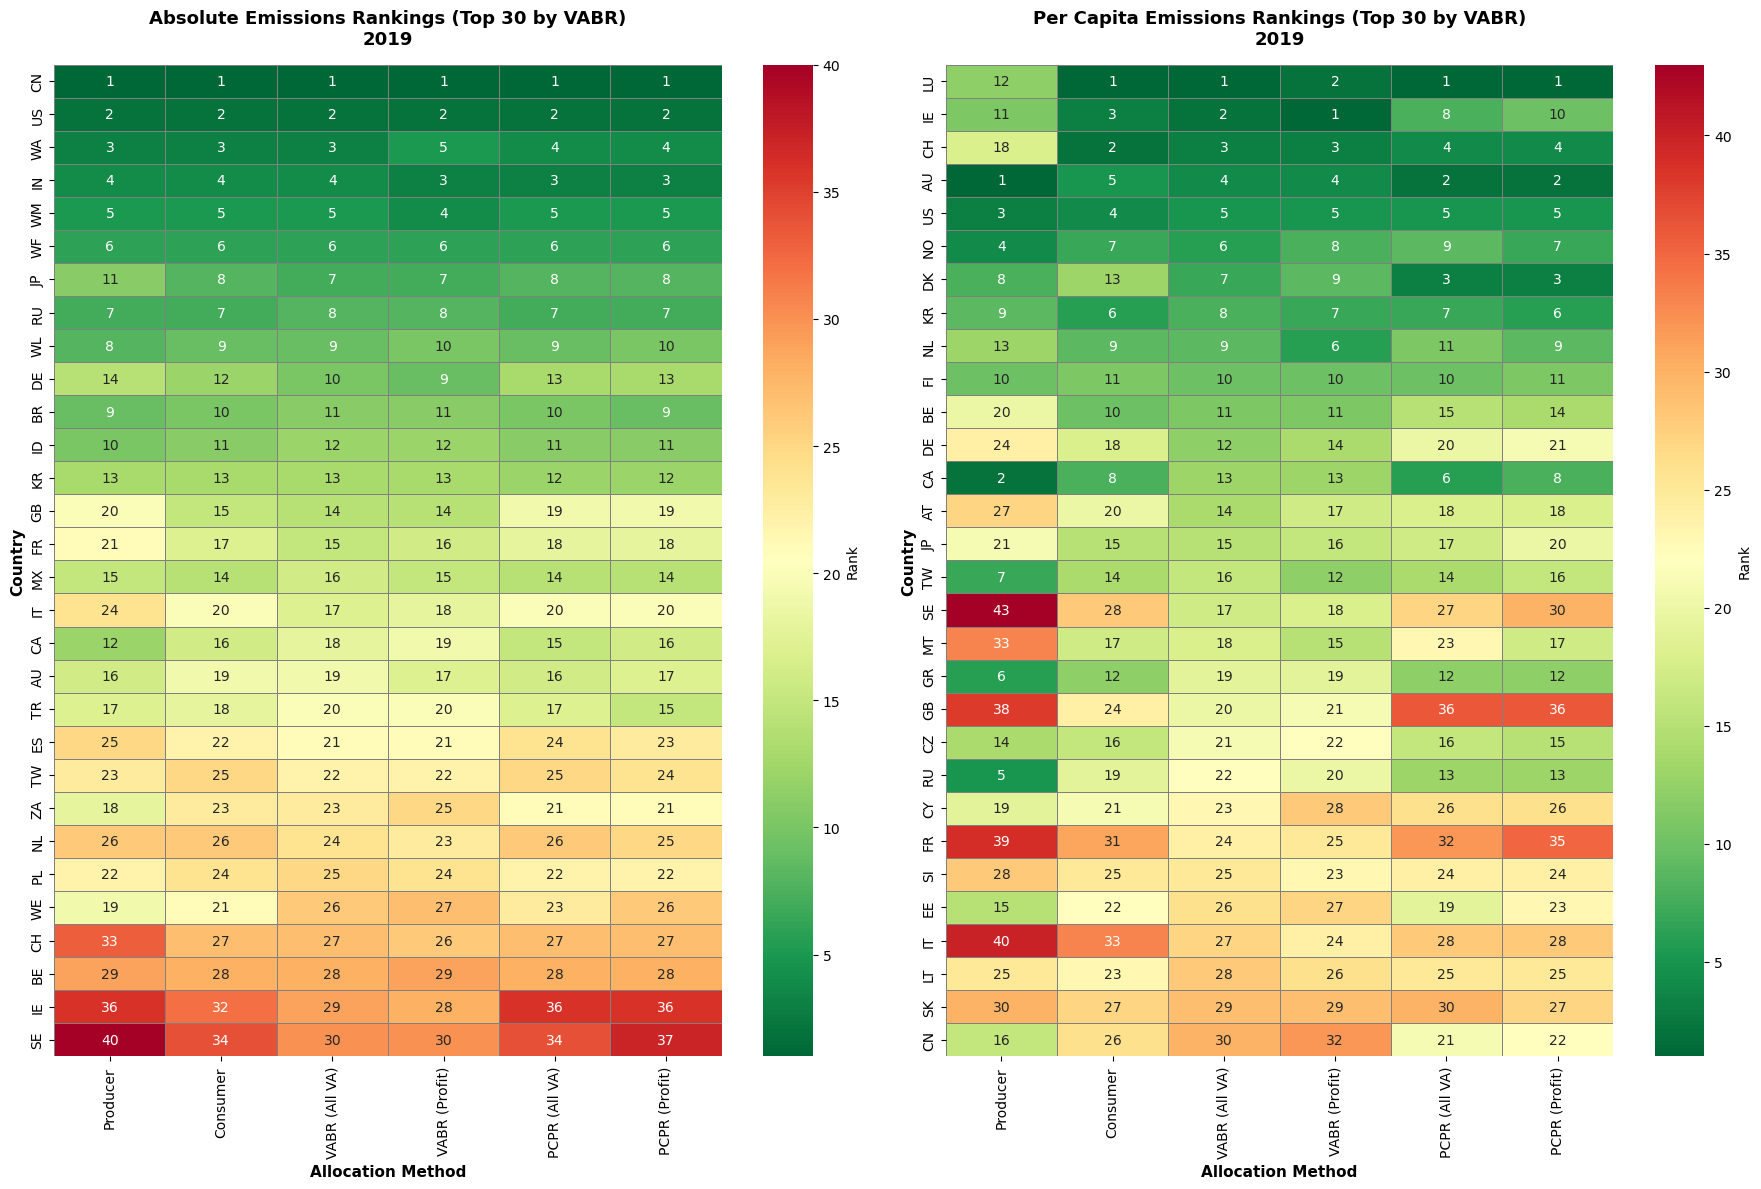


✓ Ranking heatmaps created and saved

### Ranking Stability Analysis ###

ABSOLUTE RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  WF: ranks [6. 6. 6. 6. 6. 6.], std=0.00
  MT: ranks [49. 49. 49. 49. 49. 49.], std=0.00
  US: ranks [2. 2. 2. 2. 2. 2.], std=0.00
  CN: ranks [1. 1. 1. 1. 1. 1.], std=0.00
  SK: ranks [41. 40. 40. 40. 40. 40.], std=0.41

Most volatile rankings (5 countries with largest rank variation):
  CH: ranks [33. 27. 27. 26. 27. 27.], range #26-#33, std=2.56
  GB: ranks [20. 15. 14. 14. 19. 19.], range #14-#20, std=2.79
  WE: ranks [19. 21. 26. 27. 23. 26.], range #19-#27, std=3.20
  IE: ranks [36. 32. 29. 28. 36. 36.], range #28-#36, std=3.71
  SE: ranks [40. 34. 30. 30. 34. 37.], range #30-#40, std=3.92

PER CAPITA RANKINGS:

Most stable rankings (5 countries with smallest rank variation):
  IN: ranks [48. 48. 48. 48. 48. 48.], std=0.00
  WA: ranks [47. 47. 47. 47. 47. 47.], std=0.00
  WF: ranks [49. 49. 49. 49. 49. 49.], std=0.00
  WL

Ellipsis

In [ ]:
# ===================================================================
# RANKING TABLES - ABSOLUTE AND PER CAPITA
# ===================================================================

print("\n" + "="*70)
print("RANKING TABLES: Country Rankings by Method")
print("="*70)

# ===================================================================
# 1. ABSOLUTE EMISSIONS RANKING TABLE
# ===================================================================

print("\n### ABSOLUTE EMISSIONS RANKING ###")

# Calculate ranks (already have this from before, but recalculate to be sure)
absolute_ranks = comparison_df.rank(ascending=False, method='min')

# Create ranking table: rows are ranks, columns are methods
n_countries = len(comparison_df)
n_methods = len(comparison_df.columns)

# Initialize empty DataFrame
absolute_ranking_table = pd.DataFrame(
    index=range(1, n_countries + 1),
    columns=comparison_df.columns
)
absolute_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in comparison_df.columns:
    # Sort countries by their emissions (highest first)
    sorted_countries = comparison_df[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        absolute_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nAbsolute Ranking Table (Top 20):")
print(absolute_ranking_table.head(20))

# Save to CSV
absolute_ranking_table.to_csv(RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'absolute_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 2. PER CAPITA EMISSIONS RANKING TABLE
# ===================================================================

print("\n### PER CAPITA EMISSIONS RANKING ###")

# Calculate ranks for per capita data
per_capita_ranks = per_capita.rank(ascending=False, method='min')

n_countries_pc = len(per_capita)

# Initialize empty DataFrame
per_capita_ranking_table = pd.DataFrame(
    index=range(1, n_countries_pc + 1),
    columns=per_capita.columns
)
per_capita_ranking_table.index.name = 'Rank'

# Fill table: for each method, sort countries by rank
for method in per_capita.columns:
    # Sort countries by their per capita emissions (highest first)
    sorted_countries = per_capita[method].sort_values(ascending=False)
    
    # Assign country names to ranks
    for rank, (country, value) in enumerate(sorted_countries.items(), start=1):
        per_capita_ranking_table.loc[rank, method] = f"{country} ({value:.2f})"

print("\nPer Capita Ranking Table (Top 20):")
print(per_capita_ranking_table.head(20))

# Save to CSV
per_capita_ranking_table.to_csv(RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv')
print(f"\n✓ Saved to: {RESULTS_PATH / f'per_capita_ranking_table_{SINGLE_YEAR}.csv'}")

# ===================================================================
# 3. VISUAL REPRESENTATION - HEATMAP STYLE (OPTIONAL)
# ===================================================================

print("\n### Creating Visual Ranking Heatmaps ###")

# For visual heatmap, we just show rank numbers (not country names)
# This makes it easier to see patterns

# ABSOLUTE RANKINGS HEATMAP (Top 30)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

# Get rank numbers for heatmap
absolute_rank_numbers = absolute_ranks.copy()
absolute_rank_numbers = absolute_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_absolute = absolute_rank_numbers.head(30)

# Create heatmap
sns.heatmap(
    top30_absolute,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',  # Green = high rank (worse), Red = low rank (better)
    cbar_kws={'label': 'Rank'},
    ax=ax1,
    linewidths=0.5,
    linecolor='gray'
)

ax1.set_title(f'Absolute Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax1.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax1.set_ylabel('Country', fontsize=11, fontweight='bold')

# PER CAPITA RANKINGS HEATMAP (Top 30)
per_capita_rank_numbers = per_capita_ranks.copy()
per_capita_rank_numbers = per_capita_rank_numbers.sort_values(by='VABR (All VA)')

# Show top 30 countries only
top30_per_capita = per_capita_rank_numbers.head(30)

sns.heatmap(
    top30_per_capita,
    annot=True,
    fmt='.0f',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Rank'},
    ax=ax2,
    linewidths=0.5,
    linecolor='gray'
)

ax2.set_title(f'Per Capita Emissions Rankings (Top 30 by VABR)\n{SINGLE_YEAR}',
              fontsize=13, fontweight='bold', pad=15)
ax2.set_xlabel('Allocation Method', fontsize=11, fontweight='bold')
ax2.set_ylabel('Country', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / f'ranking_heatmaps_{SINGLE_YEAR}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Ranking heatmaps created and saved")

# ===================================================================
# 4. SUMMARY STATISTICS - RANK CHANGES
# ===================================================================

print("\n### Ranking Stability Analysis ###")

# For absolute rankings
print("\nABSOLUTE RANKINGS:")
rank_std_absolute = absolute_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_absolute.head(5).index:
    ranks_list = absolute_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_absolute[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_absolute.tail(5).index:
    ranks_list = absolute_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_absolute[country]:.2f}")

# For per capita rankings
print("\nPER CAPITA RANKINGS:")
rank_std_per_capita = per_capita_ranks.std(axis=1).sort_values()

print("\nMost stable rankings (5 countries with smallest rank variation):")
for country in rank_std_per_capita.head(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    print(f"  {country}: ranks {ranks_list}, std={rank_std_per_capita[country]:.2f}")

print("\nMost volatile rankings (5 countries with largest rank variation):")
for country in rank_std_per_capita.tail(5).index:
    ranks_list = per_capita_ranks.loc[country].values
    min_rank = int(ranks_list.min())
    max_rank = int(ranks_list.max())
    print(f"  {country}: ranks {ranks_list}, range #{min_rank}-#{max_rank}, std={rank_std_per_capita[country]:.2f}")

# ===================================================================
# 5. EXPORT FULL TABLES TO EXCEL
# ===================================================================

print("\n### Exporting to Excel ###")

with pd.ExcelWriter(RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx') as writer:
    # Sheet 1: Absolute rankings
    absolute_ranking_table.to_excel(writer, sheet_name='Absolute Rankings')
    
    # Sheet 2: Per capita rankings
    per_capita_ranking_table.to_excel(writer, sheet_name='Per Capita Rankings')
    
    # Sheet 3: Absolute rank numbers (for further analysis)
    absolute_ranks.to_excel(writer, sheet_name='Absolute Rank Numbers')
    
    # Sheet 4: Per capita rank numbers
    per_capita_ranks.to_excel(writer, sheet_name='Per Capita Rank Numbers')
    
    # Sheet 5: Summary statistics
    summary_df = pd.DataFrame({
        'Absolute_Mean_Rank': absolute_ranks.mean(),
        'Absolute_Std_Rank': absolute_ranks.std(),
        'PerCapita_Mean_Rank': per_capita_ranks.mean(),
        'PerCapita_Std_Rank': per_capita_ranks.std()
    })
    summary_df.to_excel(writer, sheet_name='Summary')

print(f"✓ Saved comprehensive Excel file to: {RESULTS_PATH / f'ranking_tables_{SINGLE_YEAR}.xlsx'}")

print("\n" + "="*70)
print("✓ ALL RANKING TABLES COMPLETE")
print("="*70)
...


ANALYSIS 3: World Map - Dominant Method per Capita (2019)

Countries by dominant method:
VABR        30
Producer    14
Consumer     5
Name: dominant_method, dtype: int64

Expanded to 227 countries/territories
Countries with data: 161


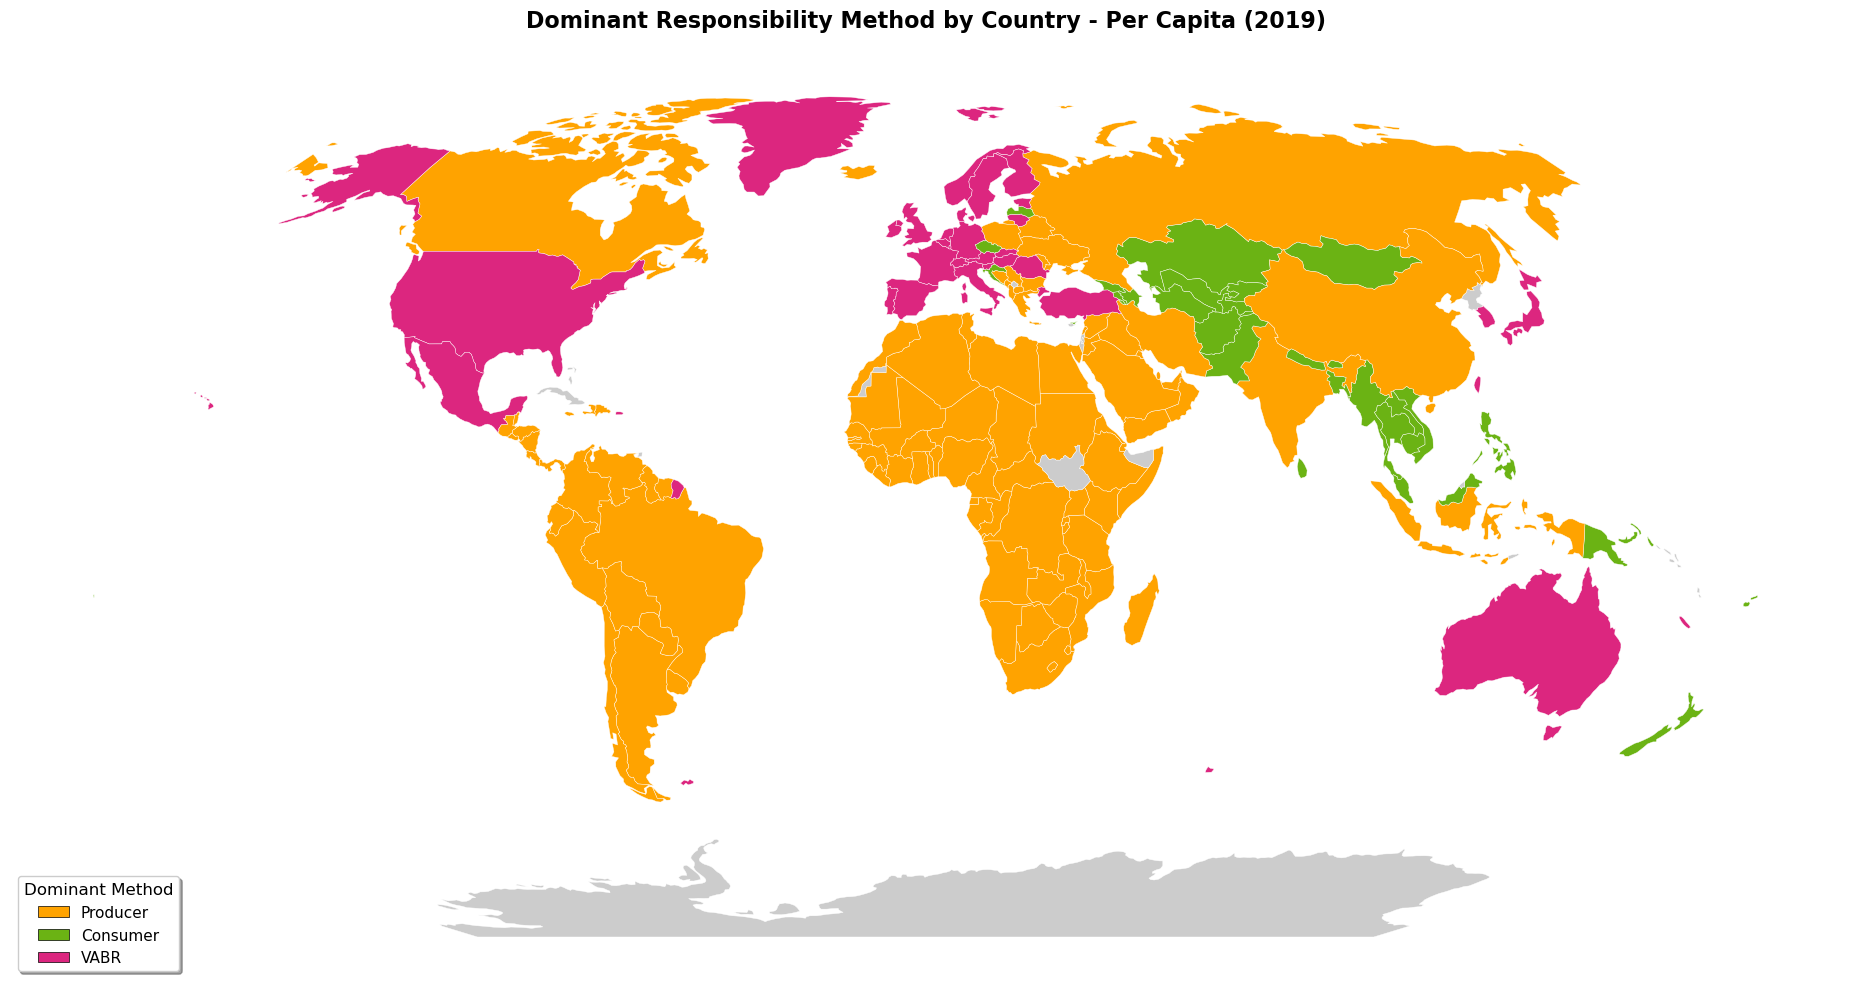


✓ World map created

Countries by dominant method:
Producer    98
VABR        34
Consumer    29
Name: dominant_method, dtype: int64


In [11]:
# ===================================================================
# ANALYSIS 3: WORLD MAP - DOMINANT RESPONSIBILITY METHOD
# ===================================================================

print("\n" + "="*70)
print(f"ANALYSIS 3: World Map - Dominant Method per Capita ({SINGLE_YEAR})")
print("="*70)

import geopandas as gpd
from matplotlib.patches import Rectangle

# ===================================================================
# PREPARE DATA: Determine dominant method for each country
# ===================================================================

# Create DataFrame with all methods
map_input = pd.DataFrame({
    'Producer': per_capita['Producer'],
    'Consumer': per_capita['Consumer'],
    'VABR': per_capita['VABR (Profit)']  # or whichever VABR variant you want
})

# Find dominant method for each country
map_input['dominant_method'] = map_input[['Producer', 'Consumer', 'VABR']].idxmax(axis=1)
map_input['max_value'] = map_input[['Producer', 'Consumer', 'VABR']].max(axis=1)

print(f"\nCountries by dominant method:")
print(map_input['dominant_method'].value_counts())

# ===================================================================
# COUNTRY CODE MAPPING
# ===================================================================

# EXIOBASE country codes to shapefile SOV_A3 codes
exiobase_to_sov = {
    'AT': 'AUT', 'BE': 'BEL', 'BG': 'BGR', 'CY': 'CYN', 'CZ': 'CZE',
    'DE': 'DEU', 'DK': 'DN1', 'EE': 'EST', 'ES': 'ESP', 'FI': 'FI1',
    'FR': 'FR1', 'GR': 'GRC', 'HR': 'HRV', 'HU': 'HUN', 'IE': 'IRL',
    'IT': 'ITA', 'LT': 'LTU', 'LU': 'LUX', 'LV': 'LVA', 'MT': 'MLT',
    'NL': 'NL1', 'PL': 'POL', 'PT': 'PRT', 'RO': 'ROU', 'SE': 'SWE',
    'SI': 'SVN', 'SK': 'SVK', 'GB': 'GB1', 'US': 'US1', 'JP': 'JPN',
    'CN': 'CH1', 'CA': 'CAN', 'KR': 'KOR', 'BR': 'BRA', 'IN': 'IND',
    'MX': 'MEX', 'RU': 'RUS', 'AU': 'AU1', 'CH': 'CHE', 'TR': 'TUR',
    'TW': 'TWN', 'NO': 'NOR', 'ID': 'IDN', 'ZA': 'ZAF'
}

# ISO2 to SOV_A3 for ROW regions
iso2_to_sov = {
    'AF': 'AFG', 'AL': 'ALB', 'DZ': 'DZA', 'AO': 'AGO', 'AR': 'ARG',
    'AM': 'ARM', 'AZ': 'AZE', 'BD': 'BGD', 'BH': 'BHR', 'BY': 'BLR',
    'BZ': 'BLZ', 'BJ': 'BEN', 'BT': 'BTN', 'BO': 'BOL', 'BA': 'BIH',
    'BW': 'BWA', 'BF': 'BFA', 'BI': 'BDI', 'KH': 'KHM', 'CM': 'CMR',
    'CV': 'CPV', 'CF': 'CAF', 'TD': 'TCD', 'CL': 'CHL', 'CO': 'COL',
    'KM': 'COM', 'CG': 'COG', 'CD': 'COD', 'CR': 'CRI', 'CI': 'CIV',
    'CU': 'CUB', 'DJ': 'DJI', 'DO': 'DOM', 'EC': 'ECU', 'EG': 'EGY',
    'SV': 'SLV', 'GQ': 'GNQ', 'ER': 'ERI', 'ET': 'ETH', 'FJ': 'FJI',
    'GA': 'GAB', 'GM': 'GMB', 'GE': 'GEO', 'GH': 'GHA', 'GT': 'GTM',
    'GN': 'GIN', 'GW': 'GNB', 'GY': 'GUY', 'HT': 'HTI', 'HN': 'HND',
    'IS': 'ISL', 'IR': 'IRN', 'IQ': 'IRQ', 'IL': 'ISR', 'JM': 'JAM',
    'JO': 'JOR', 'KE': 'KEN', 'KW': 'KWT', 'KG': 'KGZ', 'LA': 'LAO',
    'LB': 'LBN', 'LS': 'LSO', 'LR': 'LBR', 'LY': 'LBY', 'MK': 'MKD',
    'MG': 'MDG', 'MW': 'MWI', 'MY': 'MYS', 'MV': 'MDV', 'ML': 'MLI',
    'MR': 'MRT', 'MU': 'MUS', 'MD': 'MDA', 'MN': 'MNG', 'ME': 'MNE',
    'MA': 'MAR', 'MZ': 'MOZ', 'MM': 'MMR', 'NA': 'NAM', 'NP': 'NPL',
    'NZ': 'NZ1', 'NI': 'NIC', 'NE': 'NER', 'NG': 'NGA', 'OM': 'OMN',
    'PK': 'PAK', 'PA': 'PAN', 'PG': 'PNG', 'PY': 'PRY', 'PE': 'PER',
    'PH': 'PHL', 'QA': 'QAT', 'RW': 'RWA', 'SA': 'SAU', 'SN': 'SEN',
    'RS': 'SRB', 'SC': 'SYC', 'SL': 'SLE', 'SG': 'SGP', 'SO': 'SOM',
    'LK': 'LKA', 'SD': 'SDN', 'SR': 'SUR', 'SZ': 'SWZ', 'SY': 'SYR',
    'TJ': 'TJK', 'TZ': 'TZA', 'TH': 'THA', 'TG': 'TGO', 'TN': 'TUN',
    'TM': 'TKM', 'UG': 'UGA', 'UA': 'UKR', 'AE': 'ARE', 'UY': 'URY',
    'UZ': 'UZB', 'VE': 'VEN', 'VN': 'VNM', 'YE': 'YEM', 'ZM': 'ZMB',
    'ZW': 'ZWE', 'KZ': 'KA1'
}

# ROW regions and their member countries
row_regions = {
    'WA': ['AF', 'AS', 'AM', 'AZ', 'BD', 'BT', 'BN', 'KH', 'CK', 'FJ', 'PF', 'GE',
           'GU', 'HK', 'KZ', 'KI', 'KP', 'KG', 'LA', 'MO', 'MY', 'MV', 'MH', 'FM',
           'MN', 'MM', 'NR', 'NP', 'NC', 'NZ', 'NU', 'MP', 'PK', 'PW', 'PG', 'PH',
           'PN', 'WS', 'SG', 'SB', 'LK', 'TJ', 'TH', 'TP', 'TK', 'TO', 'TM', 'TV',
           'UZ', 'VU', 'VN'],
    'WL': ['AI', 'AG', 'AR', 'AW', 'BS', 'BB', 'BZ', 'BM', 'BO', 'KY', 'CL', 'CO',
           'CR', 'CU', 'DM', 'DO', 'EC', 'SV', 'FK', 'GL', 'GD', 'GP', 'GT', 'GY',
           'HT', 'HN', 'JM', 'MQ', 'NI', 'PA', 'PY', 'PE', 'PR', 'KN', 'LC', 'PM',
           'VC', 'SR', 'TT', 'TC', 'UY', 'VE', 'VG', 'VI', 'GF'],
    'WE': ['AL', 'AD', 'BY', 'BA', 'FO', 'GI', 'IS', 'IM', 'LI', 'MK', 'MD', 'MC',
           'ME', 'SM', 'RS', 'UA', 'VA'],
    'WF': ['DZ', 'AO', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CD',
           'CG', 'CI', 'DJ', 'GQ', 'EH', 'ER', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'KE',
           'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR', 'MU', 'YT', 'MA', 'MZ', 'NA',
           'NE', 'NG', 'RE', 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'SH', 'SD', 'SZ',
           'TZ', 'TG', 'TN', 'UG', 'ZM', 'ZW'],
    'WM': ['BH', 'IR', 'IQ', 'IL', 'JO', 'KW', 'LB', 'OM', 'PS', 'QA', 'SA',
           'SY', 'AE', 'YE', 'EG']
}

# ===================================================================
# EXPAND DATA: Map EXIOBASE countries and ROW regions to shapefile
# ===================================================================

map_data = []

for country_code, row_data in map_input.iterrows():
    if country_code in exiobase_to_sov:
        # Individual EXIOBASE country
        map_data.append({
            'SOV_A3': exiobase_to_sov[country_code],
            'dominant_method': row_data['dominant_method'],
            'max_value': row_data['max_value'],
            'Producer': row_data['Producer'],
            'Consumer': row_data['Consumer'],
            'VABR': row_data['VABR']
        })
    elif country_code in row_regions:
        # ROW region - assign to all member countries
        for member_iso2 in row_regions[country_code]:
            member_sov = iso2_to_sov.get(member_iso2, member_iso2)
            map_data.append({
                'SOV_A3': member_sov,
                'dominant_method': row_data['dominant_method'],
                'max_value': row_data['max_value'],
                'Producer': row_data['Producer'],
                'Consumer': row_data['Consumer'],
                'VABR': row_data['VABR']
            })

map_df = pd.DataFrame(map_data)
print(f"\nExpanded to {len(map_df)} countries/territories")

# ===================================================================
# LOAD SHAPEFILE AND MERGE
# ===================================================================

# Load world shapefile
shapefile_path = BASE_PATH / "results" / "geodata" / "ne_110m_admin_0_countries" / "ne_110m_admin_0_countries.shp"
world = gpd.read_file(shapefile_path)
world = world.to_crs('ESRI:54030')  # Robinson projection

# Merge data
world = world.merge(map_df, on='SOV_A3', how='left')

print(f"Countries with data: {world['dominant_method'].notna().sum()}")

# ===================================================================
# CREATE MAP
# ===================================================================

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Method colors
method_colors = {
    'Producer': '#ffa300',
    'Consumer': '#6bb314',
    'VABR': '#dc267f'
}

# Assign colors
world['color'] = world['dominant_method'].map(method_colors)
world['color'] = world['color'].fillna('#CCCCCC')  # Gray for missing data

# Plot
world.plot(
    color=world['color'],
    linewidth=0.3,
    edgecolor='white',
    ax=ax,
    missing_kwds={'color': '#CCCCCC', 'edgecolor': 'white', 'linewidth': 0.3}
)

# Ocean background
ax.set_facecolor('#E6F3FF')
ax.axis('off')

# Title
ax.set_title(
    f'Dominant Responsibility Method by Country - Per Capita ({SINGLE_YEAR})',
    fontsize=16, fontweight='bold', pad=20
)

# Legend
legend_elements = [
    Rectangle((0, 0), 1, 1, fc='#ffa300', edgecolor='black', linewidth=0.5, label='Producer'),
    Rectangle((0, 0), 1, 1, fc='#6bb314', edgecolor='black', linewidth=0.5, label='Consumer'),
    Rectangle((0, 0), 1, 1, fc='#dc267f', edgecolor='black', linewidth=0.5, label='VABR')
]

ax.legend(
    handles=legend_elements,
    loc='lower left',
    title='Dominant Method',
    frameon=True,
    fancybox=True,
    shadow=True,
    fontsize=11,
    title_fontsize=12
)

plt.tight_layout()
plt.show()

print("\n✓ World map created")
print(f"\nCountries by dominant method:")
print(world['dominant_method'].value_counts())


SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit)
Analyzing countries: ['US', 'DE', 'CN', 'WM', 'RU', 'IN']

Processing US...
  Categories found: 16
  Available categories: ['Agriculture', 'Chemicals & Plastics', 'Coal', 'Construction & Trade', 'Energy & Utilities Infrastructure', 'Gas', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Oil', 'Renewables', 'Services', 'Transport', 'Waste & Recycling']

Processing DE...
  Categories found: 16
  Available categories: ['Agriculture', 'Chemicals & Plastics', 'Coal', 'Construction & Trade', 'Energy & Utilities Infrastructure', 'Gas', 'Manufacturing (Food & Beverages)', 'Manufacturing (Machinery & Equipment)', 'Manufacturing (Textiles, Leather & Wood)', 'Metals', 'Non-metallic Minerals', 'Oil', 'Renewables', 'Services', 'Transport', 'Waste & Recycling']

Processing CN...
  Categories found: 16
  Available categories: ['Agriculture', 

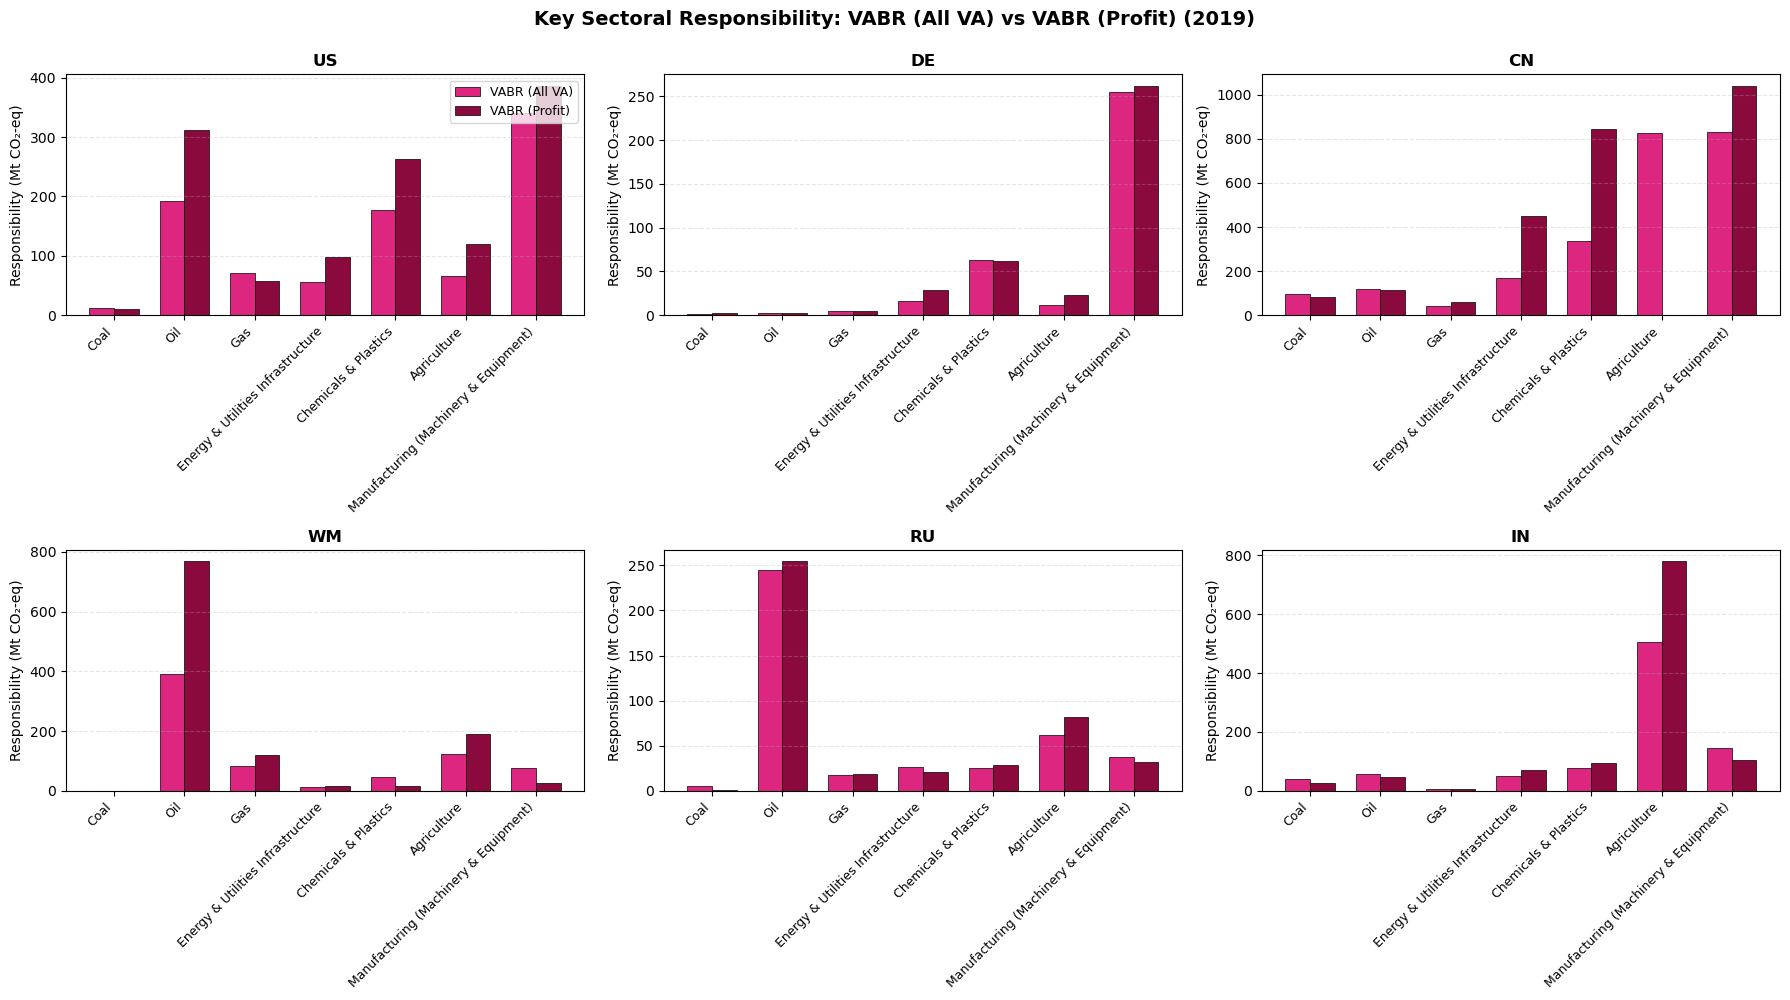


✓ Focused sectoral comparison created

### PROFIT RATIOS FOR KEY SECTORS ###

US:
  Coal                     : 0.94x ↓ (12.1 → 11.3 Mt)
  Oil                      : 1.62x ↑ (192.8 → 312.3 Mt)
  Gas                      : 0.81x ↓ (71.9 → 58.1 Mt)
  Energy & Utilities Infrastructure: 1.74x ↑ (56.1 → 97.3 Mt)
  Chemicals & Plastics     : 1.49x ↑ (176.8 → 263.3 Mt)
  Agriculture              : 1.80x ↑ (66.8 → 120.6 Mt)
  Manufacturing (Machinery & Equipment): 1.13x ↑ (340.7 → 386.2 Mt)

DE:
  Coal                     : 1.55x ↑ (1.9 → 2.9 Mt)
  Oil                      : 1.25x ↑ (2.2 → 2.7 Mt)
  Gas                      : 1.08x ↑ (4.4 → 4.8 Mt)
  Energy & Utilities Infrastructure: 1.83x ↑ (15.9 → 29.1 Mt)
  Chemicals & Plastics     : 0.99x → (62.7 → 62.3 Mt)
  Agriculture              : 1.86x ↑ (12.3 → 22.8 Mt)
  Manufacturing (Machinery & Equipment): 1.03x → (254.6 → 261.8 Mt)

CN:
  Coal                     : 0.85x ↓ (97.1 → 82.9 Mt)
  Oil                      : 0.94x ↓ (119.7 → 112.9 Mt

In [73]:
# ===================================================================
# SECTORAL ANALYSIS: VABR (All VA) vs VABR (Profit) BY COUNTRY
# FOCUSED ON KEY SECTORS
# ===================================================================

print("\n" + "="*70)
print("SECTORAL COMPARISON: VABR (All VA) vs VABR (Profit)")
print("="*70)

# Define countries to analyze
countries_to_analyze = ['US', 'DE', 'CN', 'WM', 'RU', 'IN']  

print(f"Analyzing countries: {countries_to_analyze}")

# Check which countries exist in data
available_countries = list(vabr_all_details.keys())
countries_to_analyze = [c for c in countries_to_analyze if c in available_countries]

if len(countries_to_analyze) < 6:
    print(f"⚠ Warning: Some countries not found. Available: {available_countries[:10]}...")
    print(f"Using available countries: {countries_to_analyze}")

# ===================================================================
# Helper function: Aggregate sectors to categories
# ===================================================================

def aggregate_sectors_to_categories(sector_series):
    """
    Aggregiert Sektor-Level Emissionen nach aggregierten Kategorien.
    """
    data = []
    
    for (region, sector), value in sector_series.items():
        category = category_of(sector)
        data.append({
            'category': category,
            'emissions': value
        })
    
    # Aggregate by category
    df = pd.DataFrame(data)
    category_totals = df.groupby('category')['emissions'].sum()
    
    return category_totals

# ===================================================================
# Aggregate data for each country
# ===================================================================

sectoral_comparison = {}

for country in countries_to_analyze:
    print(f"\nProcessing {country}...")
    
    # Get sector-level data for this country
    vabr_all_sectors = vabr_all_details[country]
    vabr_profit_sectors = vabr_profit_details[country]
    
    # Aggregate to categories
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors)
    
    # Store in dict
    sectoral_comparison[country] = pd.DataFrame({
        'VABR (All VA)': vabr_all_cat,
        'VABR (Profit)': vabr_profit_cat
    })
    
    # Convert to Mt CO2-eq for readability
    sectoral_comparison[country] = sectoral_comparison[country] / 1e6
    
    print(f"  Categories found: {len(sectoral_comparison[country])}")
    print(f"  Available categories: {sectoral_comparison[country].index.tolist()}")

# ===================================================================
# MULTI-PANEL PLOT: SPECIFIC KEY SECTORS
# ===================================================================

print("\n=== Creating focused sectoral comparison ===")

# SPECIFIC sectors to show (in this order)
focus_sectors = [
    'Coal',
    'Oil', 
    'Gas',
    "Energy & Utilities Infrastructure",
    'Chemicals & Plastics',
    'Agriculture',
    "Manufacturing (Machinery & Equipment)"
]

print(f"\nFocus sectors: {focus_sectors}")

# Create figure with subplots (2 rows, 3 columns for 6 countries)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Colors: light for All VA, dark for Profit
color_all = '#dc267f'      # Pink/Magenta
color_profit = '#8b0a3d'   # Dark magenta

for idx, country in enumerate(countries_to_analyze):
    ax = axes[idx]
    
    # Get data for focus sectors only
    country_data = sectoral_comparison[country]
    
    # Filter to focus sectors that exist in this country
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        ax.text(0.5, 0.5, f"{country}\nNo data for\nfocus sectors", 
                ha='center', va='center', fontsize=11)
        ax.set_title(country, fontsize=12, fontweight='bold')
        ax.axis('off')
        continue
    
    data = country_data.loc[available_focus]
    
    # Prepare data for plotting
    categories = data.index.tolist()
    x_pos = np.arange(len(categories))
    width = 0.35
    
    # Create bars
    ax.bar(x_pos - width/2, data['VABR (All VA)'], width, 
           label='VABR (All VA)', color=color_all, edgecolor='black', linewidth=0.5)
    ax.bar(x_pos + width/2, data['VABR (Profit)'], width,
           label='VABR (Profit)', color=color_profit, edgecolor='black', linewidth=0.5)
    
    # Formatting
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylabel('Responsibility (Mt CO₂-eq)', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Show which sectors are present
    missing = [s for s in focus_sectors if s not in available_focus]
    if missing:
        print(f"  {country}: Missing {missing}")
    
    # Legend only in first subplot
    if idx == 0:
        ax.legend(fontsize=9, loc='upper right')

# Overall title
fig.suptitle(f'Key Sectoral Responsibility: VABR (All VA) vs VABR (Profit) ({SINGLE_YEAR})',
             fontsize=14, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

print("\n✓ Focused sectoral comparison created")

# ===================================================================
# SUMMARY: Profit Ratios for Focus Sectors
# ===================================================================

print("\n### PROFIT RATIOS FOR KEY SECTORS ###")

for country in countries_to_analyze:
    print(f"\n{country}:")
    
    country_data = sectoral_comparison[country]
    available_focus = [s for s in focus_sectors if s in country_data.index]
    
    if len(available_focus) == 0:
        print("  No data for focus sectors")
        continue
    
    for sector in available_focus:
        all_va = country_data.loc[sector, 'VABR (All VA)']
        profit = country_data.loc[sector, 'VABR (Profit)']
        
        if all_va > 0:
            ratio = profit / all_va
            change = "↑" if ratio > 1.05 else ("↓" if ratio < 0.95 else "→")
            print(f"  {sector:25s}: {ratio:.2f}x {change} "
                  f"({all_va:.1f} → {profit:.1f} Mt)")
        else:
            print(f"  {sector:25s}: No emissions in All-VA")

In [44]:
# ===================================================================
# DIAGNOSTIC ANALYSIS: Detailed Sectoral Breakdown
# ===================================================================

print("\n" + "="*70)
print("DETAILED DIAGNOSTIC: VABR (All VA) vs VABR (Profit)")
print("="*70)

countries_analyzed = ['US', 'DE', 'CN', 'WM', 'RU', 'IN']  # oder WM?

# ===================================================================
# FUNCTION: Comprehensive sectoral breakdown
# ===================================================================

def analyze_sectoral_differences(country, vabr_all_sectors, vabr_profit_sectors):
    """
    Detaillierte Analyse der Unterschiede zwischen All VA und Profit.
    """
    
    print(f"\n{'='*70}")
    print(f"COUNTRY: {country}")
    print(f"{'='*70}")
    
    # Aggregate to categories
    vabr_all_cat = aggregate_sectors_to_categories(vabr_all_sectors, df_sectors)
    vabr_profit_cat = aggregate_sectors_to_categories(vabr_profit_sectors, df_sectors)
    
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'VABR_All': vabr_all_cat / 1e6,  # Mt
        'VABR_Profit': vabr_profit_cat / 1e6  # Mt
    })
    
    # Calculate differences
    comparison['Difference'] = comparison['VABR_Profit'] - comparison['VABR_All']
    comparison['Ratio'] = comparison['VABR_Profit'] / comparison['VABR_All']
    comparison['Percent_Change'] = (comparison['Difference'] / comparison['VABR_All']) * 100
    
    # Sort by absolute VABR_All (most important sectors)
    comparison = comparison.sort_values('VABR_All', ascending=False)
    
    # Total responsibility
    total_all = comparison['VABR_All'].sum()
    total_profit = comparison['VABR_Profit'].sum()
    
    print(f"\nTOTAL RESPONSIBILITY:")
    print(f"  VABR (All VA):  {total_all:,.1f} Mt CO2-eq")
    print(f"  VABR (Profit):  {total_profit:,.1f} Mt CO2-eq")
    print(f"  Difference:     {total_profit - total_all:,.1f} Mt ({(total_profit/total_all - 1)*100:+.1f}%)")
    
    # Show ALL categories
    print(f"\n{'FULL BREAKDOWN - ALL CATEGORIES':^70}")
    print(f"{'-'*70}")
    print(f"{'Category':<35} {'All VA':>10} {'Profit':>10} {'Diff':>8} {'Ratio':>8}")
    print(f"{'-'*70}")
    
    for category, row in comparison.iterrows():
        print(f"{category:<35} {row['VABR_All']:>10.1f} {row['VABR_Profit']:>10.1f} "
              f"{row['Difference']:>8.1f} {row['Ratio']:>8.2f}")
    
    print(f"{'-'*70}")
    print(f"{'TOTAL':<35} {total_all:>10.1f} {total_profit:>10.1f} "
          f"{total_profit - total_all:>8.1f}")
    
    # Identify interesting patterns
    print(f"\n{'KEY INSIGHTS':^70}")
    print(f"{'-'*70}")
    
    # Sectors where Profit is MUCH HIGHER (>20% increase)
    high_profit = comparison[comparison['Percent_Change'] > 20].sort_values('Percent_Change', ascending=False)
    if len(high_profit) > 0:
        print("\n✓ Sectors with HIGH profit share (>20% increase):")
        for cat, row in high_profit.head(5).iterrows():
            print(f"  {cat:<30} {row['Percent_Change']:>6.1f}% "
                  f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f} Mt)")
    
    # Sectors where Profit is MUCH LOWER (<-20% decrease)
    low_profit = comparison[comparison['Percent_Change'] < -20].sort_values('Percent_Change')
    if len(low_profit) > 0:
        print("\n✓ Sectors with LOW profit share (<-20% decrease):")
        for cat, row in low_profit.head(5).iterrows():
            print(f"  {cat:<30} {row['Percent_Change']:>6.1f}% "
                  f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f} Mt)")
    
    # Largest absolute differences
    print("\n✓ Largest ABSOLUTE differences (Mt CO2-eq):")
    abs_diff = comparison.copy()
    abs_diff['Abs_Diff'] = abs_diff['Difference'].abs()
    abs_diff = abs_diff.sort_values('Abs_Diff', ascending=False)
    
    for cat, row in abs_diff.head(5).iterrows():
        print(f"  {cat:<30} {row['Difference']:>+7.1f} Mt "
              f"({row['VABR_All']:.1f} → {row['VABR_Profit']:.1f})")
    
    return comparison

# ===================================================================
# RUN ANALYSIS FOR ALL COUNTRIES
# ===================================================================

all_results = {}

for country in countries_analyzed:
    if country not in vabr_all_details:
        print(f"\n⚠ Warning: {country} not found in data!")
        continue
    
    vabr_all_sectors = vabr_all_details[country]
    vabr_profit_sectors = vabr_profit_details[country]
    
    results = analyze_sectoral_differences(country, vabr_all_sectors, vabr_profit_sectors)
    all_results[country] = results

print("\n" + "="*70)
print("DIAGNOSTIC ANALYSIS COMPLETE")
print("="*70)


DETAILED DIAGNOSTIC: VABR (All VA) vs VABR (Profit)

COUNTRY: US

TOTAL RESPONSIBILITY:
  VABR (All VA):  6,530.8 Mt CO2-eq
  VABR (Profit):  6,591.3 Mt CO2-eq
  Difference:     60.5 Mt (+0.9%)

                   FULL BREAKDOWN - ALL CATEGORIES                    
----------------------------------------------------------------------
Category                                All VA     Profit     Diff    Ratio
----------------------------------------------------------------------
Services                                4012.9     3917.3    -95.7     0.98
Construction & Trade                     866.0      829.1    -36.9     0.96
Transport                                521.6      326.8   -194.8     0.63
Manufacturing (Machinery & Equipment)      340.7      386.2     45.5     1.13
Oil                                      192.8      312.3    119.6     1.62
Chemicals & Plastics                     176.8      263.3     86.5     1.49
Gas                                       71.9       58.1


=== Creating sectoral ratio analysis ===

Ratio DataFrame shape: (6, 6)

Ratio DataFrame:
category  Chemicals & Plastics  Coal  Gas  Metals  Oil  Services
country                                                         
CN                        2.51  0.85 1.39    0.63 0.94      0.84
DE                        0.99  1.55 1.08    0.57 1.25      1.06
IN                        1.22  0.72 0.99    0.64 0.81      0.93
RU                        1.13  0.24 1.01    1.58 1.04      1.12
US                        1.49  0.94 0.81    0.73 1.62      0.98
WM                        0.34  0.97 1.49    0.53 1.96      1.13

=== Creating ratio bar plot ===


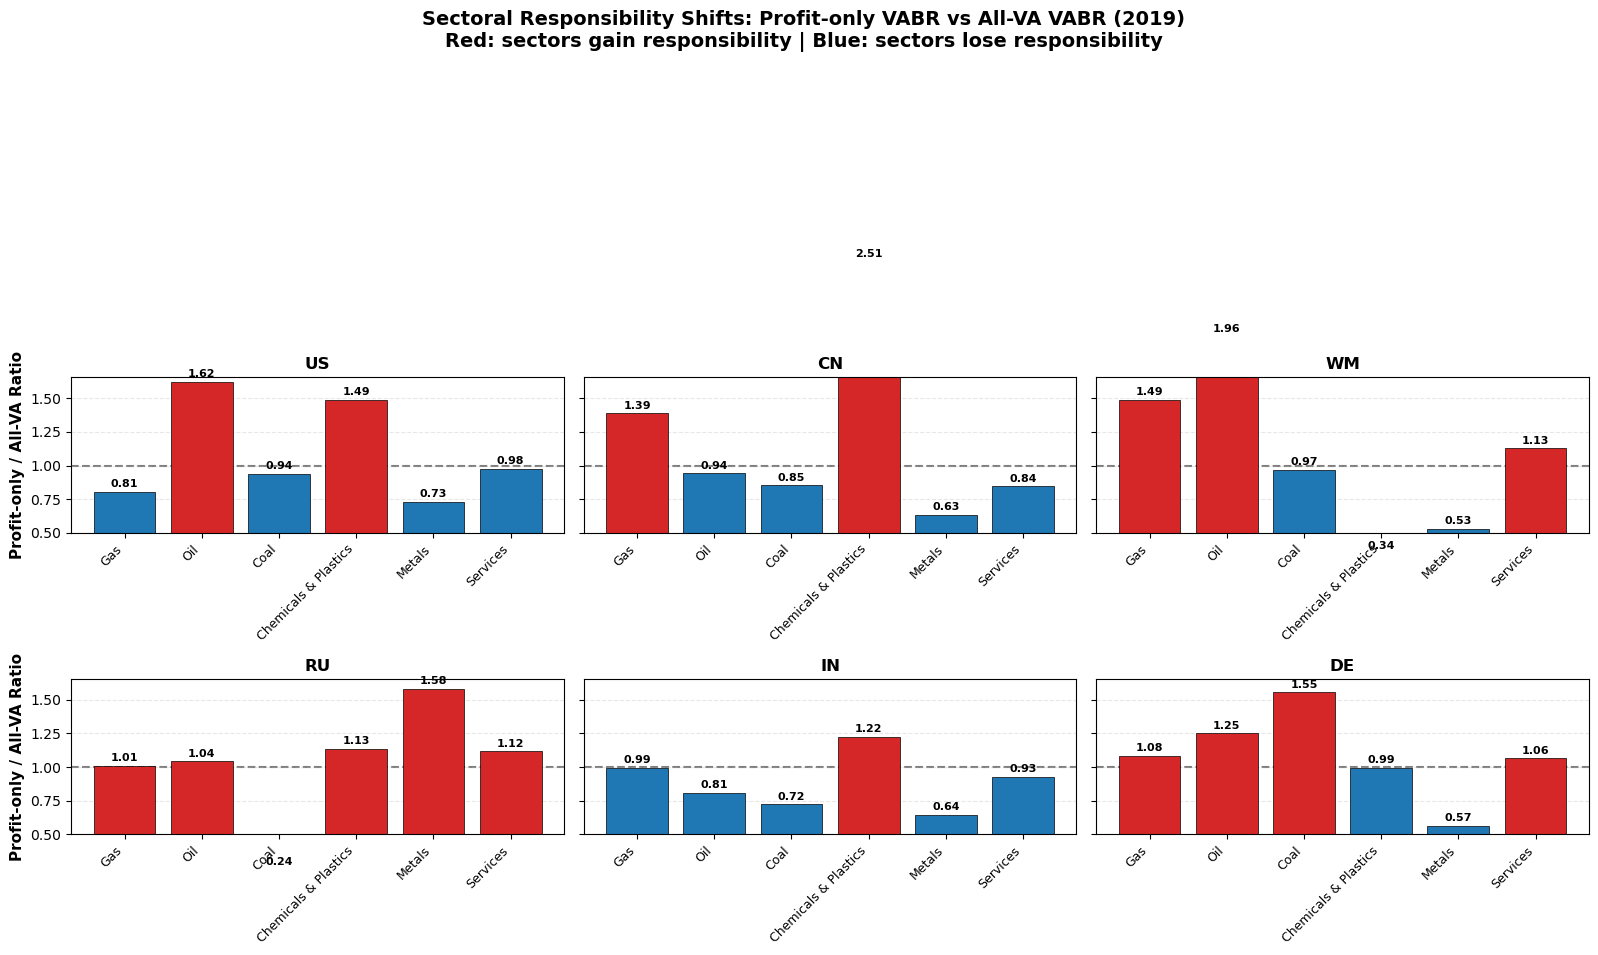


✓ Ratio bar plot created

### SECTORAL WINNERS AND LOSERS (Profit-only vs All-VA) ###

Sectors that GAIN most responsibility under Profit-only:
  Chemicals & Plastics               : 1.28x (avg across countries)
  Oil                                : 1.27x (avg across countries)
  Gas                                : 1.13x (avg across countries)
  Services                           : 1.01x (avg across countries)
  Coal                               : 0.88x (avg across countries)

Sectors that LOSE most responsibility under Profit-only:
  Oil                                : 1.27x (avg across countries)
  Gas                                : 1.13x (avg across countries)
  Services                           : 1.01x (avg across countries)
  Coal                               : 0.88x (avg across countries)
  Metals                             : 0.78x (avg across countries)

### Country-specific extremes ###

US:
  Biggest GAINER:  Oil                            (1.62x)
  Biggest LOSER:   

In [58]:
# ===================================================================
# CREATE RATIO DATAFRAME: Profit / All-VA
# ===================================================================

print("\n=== Creating sectoral ratio analysis ===")

# Countries to analyze
countries = ['US', 'CN', 'WM', 'RU', 'IN', 'DE']

# Key categories for the narrative (adjust based on your sector_classification)
key_categories = [
    "Gas",  
    "Oil",
    "Coal",
    "Chemicals & Plastics",
    "Metals",
    "Services",
]

# Build ratio matrix
ratio_data = []

for country in countries:
    if country not in sectoral_comparison:
        print(f"Warning: {country} not in data, skipping")
        continue
    
    data = sectoral_comparison[country]  # Already has 'VABR (All VA)' and 'VABR (Profit)'
    
    for category in key_categories:
        if category in data.index:
            all_va = data.loc[category, 'VABR (All VA)']
            profit = data.loc[category, 'VABR (Profit)']
            
            # Calculate ratio (avoid division by zero)
            if all_va > 0:
                ratio = profit / all_va
            else:
                ratio = np.nan
            
            ratio_data.append({
                'country': country,
                'category': category,
                'ratio': ratio,
                'all_va': all_va,
                'profit': profit
            })

# Create DataFrame
ratio_df_long = pd.DataFrame(ratio_data)

# Pivot to wide format (countries x categories)
ratio_df = ratio_df_long.pivot(index='country', columns='category', values='ratio')

print(f"\nRatio DataFrame shape: {ratio_df.shape}")
print("\nRatio DataFrame:")
print(ratio_df)   
# ===================================================================
# RATIO BAR PLOT: Sectoral shifts under profit-only VABR
# ===================================================================

print("\n=== Creating ratio bar plot ===")

fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharey=True)
axes = axes.flatten()

for ax, country in zip(axes, countries):
    if country not in ratio_df.index:
        ax.text(0.5, 0.5, f"{country}\nNo data", 
                ha='center', va='center', fontsize=12)
        ax.axis('off')
        continue
    
    ratios = ratio_df.loc[country, key_categories].dropna()
    
    # Colors: red if profit > all-VA (ratio > 1), blue if lower
    colors = ['#d62728' if r > 1 else '#1f77b4' for r in ratios]
    
    x = np.arange(len(ratios))
    
    # Horizontal reference line at 1.0 (no change)
    ax.axhline(1.0, color='black', linewidth=1.5, linestyle='--', 
               alpha=0.5, zorder=1)
    
    # Bar plot
    bars = ax.bar(x, ratios.values, color=colors, edgecolor='black', 
                   linewidth=0.5, zorder=2)
    
    # Formatting
    ax.set_xticks(x)
    ax.set_xticklabels(ratios.index, rotation=45, ha='right', fontsize=9)
    ax.set_title(country, fontsize=12, fontweight='bold')
    ax.set_ylim(0.5, max(1.5, ratios.max() + 0.1))
    ax.grid(axis='y', alpha=0.3, linestyle='--', zorder=0)
    
    # Add value labels on top of bars
    for i, (bar, val) in enumerate(zip(bars, ratios.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{val:.2f}',
                ha='center', va='bottom', fontsize=8, fontweight='bold')

# Y-axis labels
axes[0].set_ylabel('Profit-only / All-VA Ratio', fontsize=11, fontweight='bold')
axes[3].set_ylabel('Profit-only / All-VA Ratio', fontsize=11, fontweight='bold')

# Overall title
fig.suptitle(
    'Sectoral Responsibility Shifts: Profit-only VABR vs All-VA VABR (2019)\n'
    'Red: sectors gain responsibility | Blue: sectors lose responsibility',
    fontsize=14,
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

print("\n✓ Ratio bar plot created")
# ===================================================================
# QUANTITATIVE SUMMARY: Biggest Winners and Losers
# ===================================================================

print("\n### SECTORAL WINNERS AND LOSERS (Profit-only vs All-VA) ###")

# Combine all countries
all_ratios = ratio_df_long[['country', 'category', 'ratio']].dropna()

# Average ratio per category across countries
avg_ratios = all_ratios.groupby('category')['ratio'].mean().sort_values(ascending=False)

print("\nSectors that GAIN most responsibility under Profit-only:")
for category, ratio in avg_ratios.head(5).items():
    print(f"  {category:35s}: {ratio:.2f}x (avg across countries)")

print("\nSectors that LOSE most responsibility under Profit-only:")
for category, ratio in avg_ratios.tail(5).items():
    print(f"  {category:35s}: {ratio:.2f}x (avg across countries)")

# Country-specific extremes
print("\n### Country-specific extremes ###")

for country in countries:
    if country not in ratio_df.index:
        continue
    
    ratios = ratio_df.loc[country].dropna()
    max_cat = ratios.idxmax()
    min_cat = ratios.idxmin()
    
    print(f"\n{country}:")
    print(f"  Biggest GAINER:  {max_cat:30s} ({ratios[max_cat]:.2f}x)")
    print(f"  Biggest LOSER:   {min_cat:30s} ({ratios[min_cat]:.2f}x)")

In [71]:
# ===================================================================
# SECTORS WITH HIGHEST PROFIT (OPERATING SURPLUS) - CORRECT UNITS!
# ===================================================================

print("\n=== SECTORS WITH HIGHEST PROFIT COMPONENT ===")
print("(EXIOBASE values are in million €)")

# Get profit components
profit_data = ixi_data.factor_inputs.F.loc[PROFIT_COMPONENTS]

# Sum all profit components per sector
total_profit_by_sector = profit_data.sum(axis=0)

# Handle negative profits
total_profit_positive = total_profit_by_sector.copy()
n_negative = (total_profit_positive < 0).sum()
total_profit_positive[total_profit_positive < 0] = 0

print(f"\nRemoved {n_negative} sectors with negative operating surplus")

# Values are ALREADY in million €, so:
# million € / 1000 = billion € (Milliarden)
total_profit_billions = total_profit_positive / 1e3

# Sort descending
profit_sorted = total_profit_billions.sort_values(ascending=False)

# Show top 30
print("\nTop 30 sectors by total operating surplus:")
print("="*90)
print(f"{'Rank':<5}{'Region':<6}{'Sector':<55}{'Profit (bn €)':<15}{'Category'}")
print("="*90)

for i, (sector, profit) in enumerate(profit_sorted.head(30).items(), 1):
    region, sector_name = sector
    category = category_of(sector_name)
    print(f"{i:<5}{region:<6}{sector_name[:54]:<55}{profit:>10.1f} bn €    {category}")

# Total
total_global = total_profit_billions.sum()
print("\n" + "="*90)
print(f"GLOBAL TOTAL operating surplus (all sectors): {total_global:,.0f} billion € "
      f"(~{total_global*1.1:,.0f} billion USD)")

# Aggregate by category
print("\n\nOperating Surplus by CATEGORY:")
print("="*90)

profit_by_category = {}
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category not in profit_by_category:
        profit_by_category[category] = 0
    profit_by_category[category] += profit

profit_category_sorted = pd.Series(profit_by_category).sort_values(ascending=False)

for category, profit in profit_category_sorted.items():
    pct = (profit / total_global) * 100
    print(f"{category:<35s}: {profit:>10.1f} bn € ({pct:5.1f}%)")

# FOSSIL FUELS specifically
print("\n\nFOSSIL FUEL SECTORS (Top 15):")
print("="*90)

fossil_sectors_profit = []
for (region, sector_name), profit in total_profit_billions.items():
    category = category_of(sector_name)
    if category in ['Coal', 'Oil', 'Gas']:
        fossil_sectors_profit.append({
            'region': region,
            'sector': sector_name,
            'category': category,
            'profit': profit
        })

fossil_df = pd.DataFrame(fossil_sectors_profit).sort_values('profit', ascending=False)

total_fossil = fossil_df['profit'].sum()
print(f"Total Fossil Fuel Operating Surplus: {total_fossil:.1f} bn € "
      f"({total_fossil/total_global*100:.1f}% of global)")
print()

for i, (idx, row) in enumerate(fossil_df.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['region']:4s} | {row['sector'][:50]:50s} | "
          f"{row['profit']:8.1f} bn € | {row['category']}")

# Compare to Egli
print("\n\nCOMPARISON TO EGLI ET AL. (2024):")
print("="*90)
print(f"EXIOBASE 2019 Fossil Fuel Operating Surplus: ~{total_fossil:.0f} billion €")
print(f"Egli 2022 O&G Total Profits:                  $1,200 billion USD (boom year)")
print(f"Egli 2022 O&G Superprofits:                    $490 billion USD (above normal)")
print("\nNote:")
print("  - EXIOBASE 2019 = pre-pandemic, normal prices")
print("  - Egli 2022 = post-Ukraine invasion, extreme price spike")
print("  - EXIOBASE = operating surplus (broader than net profit)")
print("  - Egli = company-level net profits")


=== SECTORS WITH HIGHEST PROFIT COMPONENT ===
(EXIOBASE values are in million €)

Removed 123 sectors with negative operating surplus

Top 30 sectors by total operating surplus:
Rank RegionSector                                                 Profit (bn €)  Category
1    US    Real estate activities (70)                                1691.3 bn €    Services
2    CN    Real estate activities (70)                                 514.5 bn €    Services
3    US    Other business activities (74)                              498.5 bn €    Services
4    JP    Real estate activities (70)                                 378.9 bn €    Services
5    US    Wholesale trade and commission trade, except of motor       377.8 bn €    Construction & Trade
6    WM    Extraction of crude petroleum and services related to       360.1 bn €    Oil
7    CN    Construction (45)                                           342.7 bn €    Construction & Trade
8    US    Public administration and defence; compulso

In [83]:
# ===================================================================
# MOST INEFFICIENT SECTORS (FILTERED - realistic sectors only)
# ===================================================================

print("\n=== MOST INEFFICIENT SECTORS (Filtered, realistic only) ===")

# Filter: Only sectors with output > 1000 (to avoid division by tiny numbers)
min_output = 1000 

# Get sectors with sufficient output
sufficient_output = total_output > min_output
intensity_filtered = intensity_series[sufficient_output]

# Sort descending
intensity_sorted_filtered = intensity_filtered.sort_values(ascending=False)

print(f"\nSectors analyzed: {len(intensity_filtered)} (filtered from {len(intensity_series)})")
print("\nTop 30 most emission-intensive PRODUCTIVE sectors:")
print("="*80)

for i, ((region, sector), intensity) in enumerate(intensity_sorted_filtered.head(30).items(), 1):
    category = category_of(sector)
    output = total_output[ixi_data.x.index.get_loc((region, sector))]
    print(f"{i:2d}. {region:4s} | {sector[:40]:40s} | {intensity:8.0f} t/M€ | {category}")

# ===================================================================
# CATEGORY AVERAGES (excluding extreme outliers)
# ===================================================================

print("\n\nCategory averages (productive sectors only):")
print("="*80)

category_intensities_filtered = {}

for (region, sector), intensity in intensity_filtered.items():
    category = category_of(sector)
    if category not in category_intensities_filtered:
        category_intensities_filtered[category] = []
    category_intensities_filtered[category].append(intensity)

# Calculate average per category
category_avg_filtered = {cat: np.mean(vals) for cat, vals in category_intensities_filtered.items()}
category_sorted_filtered = pd.Series(category_avg_filtered).sort_values(ascending=False)

for category, avg_intensity in category_sorted_filtered.items():
    n_sectors = len(category_intensities_filtered[category])
    print(f"{category:35s}: {avg_intensity:8.0f} t/M€ (n={n_sectors})")


=== MOST INEFFICIENT SECTORS (Filtered, realistic only) ===

Sectors analyzed: 3508 (filtered from 7987)

Top 30 most emission-intensive PRODUCTIVE sectors:
 1. IN   | Cattle farming                           | 108932862223 t/M€ | Agriculture
 2. IN   | Production of electricity by coal        | 80275527921 t/M€ | Coal
 3. TW   | Production of electricity by coal        | 72814781673 t/M€ | Coal
 4. ZA   | Production of electricity by coal        | 68309533029 t/M€ | Coal
 5. WE   | Production of electricity by coal        | 56352301683 t/M€ | Coal
 6. WF   | Mining of coal and lignite; extraction o | 45746055523 t/M€ | Coal
 7. WA   | Production of electricity by coal        | 35011432885 t/M€ | Coal
 8. BR   | Landfill of waste: Food                  | 28565846348 t/M€ | Waste & Recycling
 9. TW   | Production of electricity by gas         | 27604065307 t/M€ | Gas
10. US   | Production of electricity by coal        | 26847077757 t/M€ | Coal
11. WA   | Cultivation of paddy rice      

EFFICIENCY BIAS


=== EFFICIENCY BIAS ANALYSIS ===

Data points: 35
  sector country   intensity  va_coeff    label
0   Coal      EU  8955105.58      0.28  EU Coal
1   Coal      CN  7125291.89      0.14  CN Coal
2   Coal      IN 15119384.20      0.52  IN Coal
3   Coal      US 15156677.35      0.42  US Coal
4   Coal      RU  9010788.93      0.19  RU Coal
5   Coal      WM 26533459.67      0.05  WM Coal
6   Coal      AU  1976536.18      0.68  AU Coal
7    Oil      EU   521121.60      0.14   EU Oil
8    Oil      CN   369497.86      0.12   CN Oil
9    Oil      IN   421965.99      0.17   IN Oil


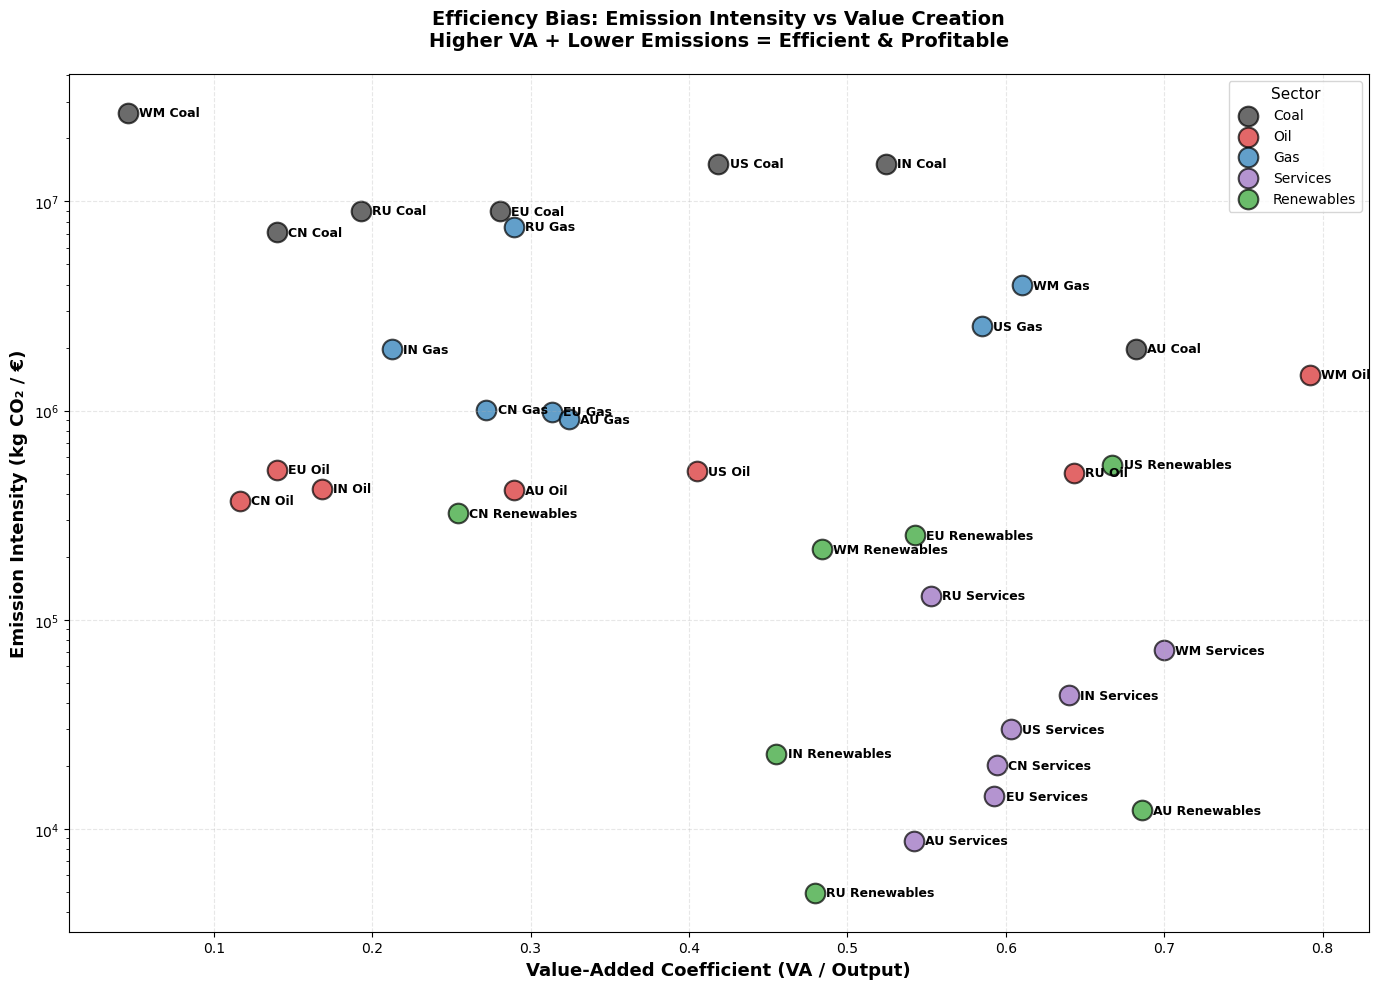


✓ Efficiency bias scatterplot created

### EFFICIENCY BIAS PATTERNS ###

Most emission-intensive (top 5):
  WM Coal                  : 26533460 kg/€, VA=0.046
  US Coal                  : 15156677 kg/€, VA=0.419
  IN Coal                  : 15119384 kg/€, VA=0.524
  RU Coal                  :  9010789 kg/€, VA=0.193
  EU Coal                  :  8955106 kg/€, VA=0.281

Highest value-added (top 5):
  WM Oil                   : VA=0.792,  1484073 kg/€
  WM Services              : VA=0.700,    71573 kg/€
  AU Renewables            : VA=0.686,    12243 kg/€
  AU Coal                  : VA=0.682,  1976536 kg/€
  US Renewables            : VA=0.667,   551752 kg/€

'Dirty but poor' sectors (high emissions, low value):
  EU Coal                  :  8955106 kg/€, VA=0.281
  CN Coal                  :  7125292 kg/€, VA=0.140
  US Coal                  : 15156677 kg/€, VA=0.419
  RU Coal                  :  9010789 kg/€, VA=0.193
  WM Coal                  : 26533460 kg/€, VA=0.046
  EU Oil     

In [95]:
# ===================================================================
# EFFICIENCY BIAS SCATTERPLOT
# Emission Intensity vs Value-Added Coefficients
# ===================================================================

print("\n=== EFFICIENCY BIAS ANALYSIS ===")

# EU countries
eu_countries = [
    'AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 
    'FR', 'GR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 
    'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'GB'
]

# Sectors to analyze
focus_sectors = ['Coal', 'Oil', 'Gas', 
                 'Services', 'Renewables']

# Country groups
country_groups = ['EU', 'CN', 'IN', 'US', 'RU', 'WM', 'AU']

# ===================================================================
# STEP 1: Calculate emission intensity and VA coefficients per sector
# ===================================================================

# Emission intensity (kg CO2 per €)
emission_intensity_kg = emission_intensity * 1000
intensity_series = pd.Series(emission_intensity_kg, index=ixi_data.x.index)

# Value-added coefficients (already calculated)
va_series = pd.Series(v_clean_all, index=ixi_data.x.index)

# ===================================================================
# STEP 2: Aggregate by sector category and country/region
# ===================================================================

plot_data = []

for sector_cat in focus_sectors:
    for country_group in country_groups:
        
        # Select regions
        if country_group == 'EU':
            regions_to_include = eu_countries
        else:
            regions_to_include = [country_group]
        
        # Filter sectors by category and region
        mask = pd.Series([
            (region in regions_to_include and category_of(sector) == sector_cat)
            for region, sector in ixi_data.x.index
        ], index=ixi_data.x.index)
        
        if mask.sum() == 0:
            continue  # No sectors found
        
        # Get values for these sectors
        intensities = intensity_series[mask]
        va_coeffs = va_series[mask]
        outputs = total_output[mask.values]
        
        # Weight by output for averaging
        if outputs.sum() > 0:
            avg_intensity = np.average(intensities, weights=outputs)
            avg_va = np.average(va_coeffs, weights=outputs)
            
            plot_data.append({
                'sector': sector_cat,
                'country': country_group,
                'intensity': avg_intensity,
                'va_coeff': avg_va,
                'label': f"{country_group} {sector_cat}"
            })

# Create DataFrame
df_plot = pd.DataFrame(plot_data)

print(f"\nData points: {len(df_plot)}")
print(df_plot.head(10))

# ===================================================================
# STEP 3: Create Scatterplot
# ===================================================================

# Colors per sector
sector_colors = {
    'Coal': '#2c2c2c',           # Black
    'Oil': '#d62728',            # Red
    'Gas': '#1f77b4',            # Blue
    'Metals': '#bcbd22',         # Yellow-green
    'Services': '#9467bd',  # Purple
    'Renewables': '#2ca02c'      # Green
}

# Create plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot each sector
for sector in focus_sectors:
    sector_data = df_plot[df_plot['sector'] == sector]
    
    ax.scatter(
        sector_data['va_coeff'],
        sector_data['intensity'],
        c=sector_colors[sector],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5,
        label=sector
    )
    
    # Add labels to points
    for _, row in sector_data.iterrows():
        ax.annotate(
            row['label'],
            (row['va_coeff'], row['intensity']),
            xytext=(8, 0),
            textcoords='offset points',
            fontsize=9,
            fontweight='bold',
            va='center'
        )

# Formatting
ax.set_xlabel('Value-Added Coefficient (VA / Output)', 
              fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO₂ / €)', 
              fontsize=13, fontweight='bold')
ax.set_title('Efficiency Bias: Emission Intensity vs Value Creation\n'
             'Higher VA + Lower Emissions = Efficient & Profitable',
             fontsize=14, fontweight='bold', pad=20)

# Log scale for Y-axis (emission intensity varies widely)
ax.set_yscale('log')

# Grid
ax.grid(True, alpha=0.3, linestyle='--')

# Legend
ax.legend(title='Sector', fontsize=10, title_fontsize=11, 
          loc='upper right')

plt.tight_layout()
plt.show()

print("\n✓ Efficiency bias scatterplot created")

# ===================================================================
# SUMMARY: Identify patterns
# ===================================================================

print("\n### EFFICIENCY BIAS PATTERNS ###")

# Highest emission intensity (dirty)
print("\nMost emission-intensive (top 5):")
for _, row in df_plot.nlargest(5, 'intensity').iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

# Highest value-added (most profitable)
print("\nHighest value-added (top 5):")
for _, row in df_plot.nlargest(5, 'va_coeff').iterrows():
    print(f"  {row['label']:25s}: VA={row['va_coeff']:.3f}, {row['intensity']:8.0f} kg/€")

# "Dirty but poor" (high intensity, low VA)
print("\n'Dirty but poor' sectors (high emissions, low value):")
dirty_poor = df_plot[(df_plot['intensity'] > df_plot['intensity'].median()) & 
                     (df_plot['va_coeff'] < df_plot['va_coeff'].median())]
for _, row in dirty_poor.iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

# "Clean and rich" (low intensity, high VA)
print("\n'Clean and profitable' sectors (low emissions, high value):")
clean_rich = df_plot[(df_plot['intensity'] < df_plot['intensity'].median()) & 
                     (df_plot['va_coeff'] > df_plot['va_coeff'].median())]
for _, row in clean_rich.iterrows():
    print(f"  {row['label']:25s}: {row['intensity']:8.0f} kg/€, VA={row['va_coeff']:.3f}")

In [96]:
# ===================================================================
# DEBUG: What's in "IN Coal"?
# ===================================================================

print("\n=== DEBUGGING IN COAL AGGREGATION ===")

# Get all Indian Coal sectors
mask_in_coal = pd.Series([
    (region == 'IN' and category_of(sector) == 'Coal')
    for region, sector in ixi_data.x.index
], index=ixi_data.x.index)

print(f"\nIndian Coal sectors: {mask_in_coal.sum()}")

# Show details
for (region, sector) in ixi_data.x.index[mask_in_coal]:
    idx = ixi_data.x.index.get_loc((region, sector))
    
    intensity_kg = emission_intensity_kg[idx]
    va = v_clean_all[idx]
    output = total_output[idx]
    
    print(f"\n{sector}")
    print(f"  Emission intensity: {intensity_kg:,.0f} kg/€")
    print(f"  VA coefficient: {va:.3f}")
    print(f"  Output: {output/1e6:,.0f} M€")
    print(f"  Weight in aggregate: {output/total_output[mask_in_coal].sum()*100:.1f}%")

# Weighted average (what the plot shows)
intensities = emission_intensity_kg[mask_in_coal.values]
vas = v_clean_all[mask_in_coal.values]
outputs = total_output[mask_in_coal.values]

weighted_intensity = np.average(intensities, weights=outputs)
weighted_va = np.average(vas, weights=outputs)

print(f"\nWeighted averages (what plot shows):")
print(f"  Intensity: {weighted_intensity:,.0f} kg/€")
print(f"  VA: {weighted_va:.3f}")


=== DEBUGGING IN COAL AGGREGATION ===

Indian Coal sectors: 3

Mining of coal and lignite; extraction of peat (10)
  Emission intensity: 1,190,351 kg/€
  VA coefficient: 0.706
  Output: 0 M€
  Weight in aggregate: 74.2%

Manufacture of coke oven products
  Emission intensity: 1,438,314 kg/€
  VA coefficient: 0.009
  Output: 0 M€
  Weight in aggregate: 8.2%

Production of electricity by coal
  Emission intensity: 80,275,528 kg/€
  VA coefficient: 0.000
  Output: 0 M€
  Weight in aggregate: 17.6%

Weighted averages (what plot shows):
  Intensity: 15,119,384 kg/€
  VA: 0.524


In [ ]:
# ===================================================================
# PLOT 1: TOP 30 EMITTERS - DETAILED SCATTER
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Top 30 Emitting Sectors - Efficiency Bias Analysis")
print("="*70)

# Select top 30 by total emissions
top30 = plot_data.nlargest(30, 'total_emissions').copy()

print(f"Top 30 sectors represent: {top30['total_emissions'].sum():.2f} Gt ({top30['total_emissions'].sum()/plot_data['total_emissions'].sum()*100:.1f}% of filtered total)")

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Plot each category
for category in top30['category'].unique():
    cat_data = top30[top30['category'] == category]
    
    ax.scatter(
        cat_data['va_coefficient'],
        cat_data['emission_intensity'],
        c=[colors_map[category]],
        label=category,
        s=cat_data['total_emissions'] * 200,  # Size by emissions
        alpha=0.7,
        edgecolors='black',
        linewidths=0.5
    )

# Add labels for each point
for idx, row in top30.iterrows():
    region = row['region']
    sector_short = row['sector'][:30]  # Truncate long names
    
    # Offset text slightly to avoid overlap
    ax.annotate(
        f"{region}-{sector_short}",
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=7,
        alpha=0.8,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Top 30 Emitting Sectors: Efficiency Bias Analysis ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Sector Category',
    loc='upper right',
    frameon=True,
    fontsize=9,
    title_fontsize=10
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Top 30 scatter plot created")

# Print the list
print("\nTop 30 Sectors:")
print(top30[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient', 'category']].to_string())

In [ ]:
# ===================================================================
# COAL DEEP DIVE - TOP 10 ONLY (CLEAN & SIMPLE)
# ===================================================================

# Select TOP 15 coal sectors only
top15_coal = coal_sectors.nlargest(15, 'total_emissions').copy()

fig, ax = plt.subplots(figsize=(12, 8))

# Scatter
scatter = ax.scatter(
    top15_coal['va_coefficient'],
    top15_coal['emission_intensity'],
    s=top15_coal['total_emissions'] * 500,
    c=top15_coal['total_emissions'],
    cmap='Reds',
    alpha=0.7,
    edgecolors='black',
    linewidths=1.5
)

# Labels - manually positioned for clarity
for idx, row in top10_coal.iterrows():
    # Short label: just region + first few words of sector
    sector_words = row['sector'].split()[:3]  # First 3 words
    label = f"{row['region']}\n{' '.join(sector_words)}\n{row['total_emissions']:.2f} Gt"
    
    ax.annotate(
        label,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(10, 10),
        textcoords='offset points',
        fontsize=9,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9, edgecolor='black', linewidth=0.8),
        arrowprops=dict(arrowstyle='->', lw=0.8)
    )

ax.set_yscale('log')
ax.set_xlabel('Value-Added Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Coal Sectors: Top 15 Emitters - Efficiency Bias ({SINGLE_YEAR})',
    fontsize=13,
    fontweight='bold',
    pad=15
)

ax.grid(True, alpha=0.3, linestyle='--', which='both')
ax.set_xlim(-0.05, 0.55)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Emissions (Gt)', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# ===================================================================
# TABLE: Top 20 Coal Sectors - Complete Details
# ===================================================================

print("\n" + "="*70)
print("TABLE: Top 20 Coal Sectors - Efficiency Bias Details")
print("="*70)

top20_coal_table = coal_sectors.nlargest(20, 'total_emissions').copy()

# Create clean table
coal_table = top20_coal_table[['region', 'sector', 'total_emissions', 'emission_intensity', 'va_coefficient']].copy()
coal_table.columns = ['Region', 'Sector', 'Emissions (Gt)', 'Emission Intensity', 'VA Coefficient']
coal_table = coal_table.reset_index(drop=True)
coal_table.index = coal_table.index + 1  # Start from 1

print("\n")
print(coal_table.to_string())
print("\n")

# Summary
print("Key Statistics:")
print(f"Total (Top 20): {coal_table['Emissions (Gt)'].sum():.2f} Gt")
print(f"Average VA coefficient: {coal_table['VA Coefficient'].mean():.3f}")
print(f"Range emission intensity: {coal_table['Emission Intensity'].min():.0f} - {coal_table['Emission Intensity'].max():.0f} kg/EUR")

In [133]:
# ===================================================================
# PLOT: FOSSIL FUELS DEEP DIVE (Coal + Gas + Oil)
# ===================================================================

print("\n" + "="*70)
print("PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters")
print("="*70)

# Filter for fossil fuel sectors (Coal, Gas, Oil)
fossil_cats = ['Coal', 'Gas', 'Oil']
fossil_sectors = plot_data[plot_data['category'].isin(fossil_cats)].copy()

print(f"Total fossil fuel sectors: {len(fossil_sectors)}")
print(f"  Coal: {len(fossil_sectors[fossil_sectors['category']=='Coal'])}")
print(f"  Gas: {len(fossil_sectors[fossil_sectors['category']=='Gas'])}")
print(f"  Oil: {len(fossil_sectors[fossil_sectors['category']=='Oil'])}")
print(f"Total fossil emissions: {fossil_sectors['total_emissions'].sum():.2f} Gt")

# Select top 20 by total emissions
top20_fossil = fossil_sectors.nlargest(20, 'total_emissions').copy()

print(f"\nTop 20 represent: {top20_fossil['total_emissions'].sum():.2f} Gt ({top20_fossil['total_emissions'].sum()/fossil_sectors['total_emissions'].sum()*100:.1f}% of fossil total)")

# Create figure
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for the 3 fossil fuel types
fossil_colors = {
    'Coal': '#7f7f7f',
    'Gas': '#1f77b4', 
    'Oil': '#d62728'
}

# Plot each fossil fuel type separately
for fuel_type in ['Coal', 'Gas', 'Oil']:
    fuel_data = top20_fossil[top20_fossil['category'] == fuel_type]
    
    if len(fuel_data) > 0:
        ax.scatter(
            fuel_data['va_coefficient'],
            fuel_data['emission_intensity'],
            s=fuel_data['total_emissions'] * 400,
            c=fossil_colors[fuel_type],
            label=fuel_type,
            alpha=0.7,
            edgecolors='black',
            linewidths=1.5
        )

# Add labels for each point
for idx, row in top20_fossil.iterrows():
    region = row['region']
    # Short sector name - first 2-3 words
    sector_words = row['sector'].split()[:3]
    sector_short = ' '.join(sector_words)
    emissions_gt = row['total_emissions']
    
    label_text = f"{region}\n{sector_short}\n{emissions_gt:.2f} Gt"
    
    ax.annotate(
        label_text,
        xy=(row['va_coefficient'], row['emission_intensity']),
        xytext=(8, 5),
        textcoords='offset points',
        fontsize=7.5,
        ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='gray', linewidth=0.5),
        arrowprops=dict(arrowstyle='->', lw=0.7, color='gray')
    )

# Set y-axis to log scale
ax.set_yscale('log')

# Labels and title
ax.set_xlabel('Value-Added Coefficient', fontsize=13, fontweight='bold')
ax.set_ylabel('Emission Intensity (kg CO2-eq / EUR)', fontsize=13, fontweight='bold')
ax.set_title(
    f'Fossil Fuels: Efficiency Bias Analysis - Top 20 Emitters ({SINGLE_YEAR})\n(Bubble size = total emissions)',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', which='both')

# Legend
ax.legend(
    title='Fuel Type',
    loc='upper right',
    frameon=True,
    fontsize=11,
    title_fontsize=12,
    markerscale=1.5
)

# Set x-axis limits
ax.set_xlim(-0.05, 1.05)

plt.tight_layout()
plt.show()

print("\n✓ Fossil fuels scatter plot created")

# Print breakdown by fuel type
print("\n### Top 20 Breakdown by Fuel Type ###")
for fuel in ['Coal', 'Gas', 'Oil']:
    fuel_count = len(top20_fossil[top20_fossil['category'] == fuel])
    fuel_emissions = top20_fossil[top20_fossil['category'] == fuel]['total_emissions'].sum()
    print(f"{fuel}: {fuel_count} sectors, {fuel_emissions:.2f} Gt")


PLOT 1: Fossil Fuels Efficiency Bias - Top 20 Emitters


KeyError: 'category'

In [ ]:
# ===================================================================
# PLOT: CATEGORY-LEVEL ALLOCATION COMPARISON (BAR CHART)
# ===================================================================

print("\n" + "="*70)
print("PLOT: Sector Category Allocation - Bar Chart Comparison")
print("="*70)

# Use the category_table from before (if not already created, recreate it)
# Aggregate producer emissions by category
category_producer = bias_df_filtered.groupby('category')['total_emissions'].sum()

# Aggregate VABR by category
vabr_comparison = pd.DataFrame({
    'VABR_all': vabr_all_sector_data / 1e9,
    'VABR_profit': vabr_profit_sector_data / 1e9
})
vabr_comparison = vabr_comparison.merge(
    bias_df[['category']], 
    left_index=True, 
    right_index=True, 
    how='left'
)

category_vabr_all = vabr_comparison.groupby('category')['VABR_all'].sum()
category_vabr_profit = vabr_comparison.groupby('category')['VABR_profit'].sum()

# Create DataFrame
plot_data_cat = pd.DataFrame({
    'Producer': category_producer,
    'VABR (All VA)': category_vabr_all,
    'VABR (Profit)': category_vabr_profit
})

# Sort by Producer emissions (descending)
plot_data_cat = plot_data_cat.sort_values('Producer', ascending=False)

print(f"\nCategories: {len(plot_data_cat)}")
print(f"Total Producer: {plot_data_cat['Producer'].sum():.2f} Gt")
print(f"Total VABR (all): {plot_data_cat['VABR (All VA)'].sum():.2f} Gt")
print(f"Total VABR (profit): {plot_data_cat['VABR (Profit)'].sum():.2f} Gt")

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Bar positions
x = np.arange(len(plot_data_cat))
width = 0.28

# Plot 3 grouped bars
bars1 = ax.bar(x - width, plot_data_cat['Producer'], width, 
               label='Producer', color='#ffa300', edgecolor='black', linewidth=0.5)
bars2 = ax.bar(x, plot_data_cat['VABR (All VA)'], width,
               label='VABR (All VA)', color='#dc267f', edgecolor='black', linewidth=0.5)
bars3 = ax.bar(x + width, plot_data_cat['VABR (Profit)'], width,
               label='VABR (Profit Only)', color='#785ef0', edgecolor='black', linewidth=0.5)

# Labels and title
ax.set_xlabel('Sector Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Responsibility Allocation (Gt CO2-eq)', fontsize=12, fontweight='bold')
ax.set_title(
    f'Allocation by Sector Category: Producer vs. VABR Methods ({SINGLE_YEAR})',
    fontsize=14,
    fontweight='bold',
    pad=20
)

# Set x-axis
ax.set_xticks(x)
ax.set_xticklabels(plot_data_cat.index, rotation=45, ha='right', fontsize=10)

# Legend
ax.legend(fontsize=11, loc='upper right', frameon=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', axis='y')

plt.tight_layout()
plt.show()

print("\n✓ Category-level bar chart created")

# Print some key insights
print("\n### Key Patterns ###")

# Categories with large discrepancies
print("\nCategories where VABR (all) differs most from Producer:")
plot_data_cat['Abs_Diff'] = abs(plot_data_cat['Producer'] - plot_data_cat['VABR (All VA)'])
top_diff = plot_data_cat.nlargest(5, 'Abs_Diff')

for cat, row in top_diff.iterrows():
    ratio = (row['VABR (All VA)'] / row['Producer'] * 100) if row['Producer'] > 0 else 0
    print(f"  {cat}: Producer {row['Producer']:.2f} Gt → VABR {row['VABR (All VA)']:.2f} Gt ({ratio:.0f}%)")

TECH ADJUSTED VABR VERSION

In [116]:
# ===================================================================
# CORRECTED INTERPRETATION
# ===================================================================

print("\n" + "="*70)
print("KANDER OPTION A RESULTS (CORRECTED)")
print("="*70)

print("\n### INEFFICIENT EXPORTERS (penalized - exports dirtier than world avg) ###")
print("Positive change = exports are DIRTIER than sectoral world average\n")

penalized = comparison_kander_fixed.nlargest(10, 'Change (Gt)')
for country, row in penalized.iterrows():
    print(f"{country:4s}: {row['Standard VABR']:6.2f} → {row['Kander TCBA-VABR']:6.2f} Gt "
          f"({row['Change (Gt)']:+6.2f} Gt, {row['Change (%)']:+6.1f}%)")

print("\n### EFFICIENT EXPORTERS (rewarded - exports cleaner than world avg) ###")
print("Negative change = exports are CLEANER than sectoral world average\n")

rewarded = comparison_kander_fixed.nsmallest(10, 'Change (Gt)')
for country, row in rewarded.iterrows():
    print(f"{country:4s}: {row['Standard VABR']:6.2f} → {row['Kander TCBA-VABR']:6.2f} Gt "
          f"({row['Change (Gt)']:+6.2f} Gt, {row['Change (%)']:+6.1f}%)")

# ===================================================================
# DEVELOPING VS DEVELOPED
# ===================================================================

print("\n### AGGREGATE PATTERNS ###")

developing = ['CN', 'IN', 'BR', 'ZA', 'ID', 'TR', 'MX']
developed_eu = ['FR', 'DE', 'IT', 'GB', 'ES', 'SE', 'NL', 'BE', 'AT', 'FI']
developed_other = ['US', 'JP', 'CA', 'AU', 'KR']

dev_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developing), 'Change (Gt)'
].sum()

devd_eu_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_eu), 'Change (Gt)'
].sum()

devd_other_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_other), 'Change (Gt)'
].sum()

print(f"\nDeveloping countries: {dev_change:+.2f} Gt")
print(f"Developed EU: {devd_eu_change:+.2f} Gt")
print(f"Developed other: {devd_other_change:+.2f} Gt")
print(f"Developed total: {(devd_eu_change + devd_other_change):+.2f} Gt")

if dev_change > 0:
    print("\n→ Developing countries are PENALIZED (their exports are dirtier)")
    print("→ Kander Option A HARMS equity")
else:
    print("\n→ Developing countries are REWARDED (their exports are cleaner)")
    print("→ Kander Option A HELPS equity")

# ===================================================================
# KEY INSIGHT
# ===================================================================

print("\n### KEY INSIGHT ###")
print("\nKander Option A (TCBA-VABR):")
print("• Penalizes countries that export emission-intensive goods")
print("• Rewards countries that export clean goods")
print(f"• Result: Developing countries {dev_change:+.2f} Gt")
print("\nThis is a CONSUMER-SIDE adjustment:")
print("• Focuses on what countries TRADE")
print("• Does NOT address producer-side efficiency bias")
print("• Does NOT solve 'dirty but poor' problem")


KANDER OPTION A RESULTS (CORRECTED)

### INEFFICIENT EXPORTERS (penalized - exports dirtier than world avg) ###
Positive change = exports are DIRTIER than sectoral world average

WM  :   2.46 →   2.81 Gt ( +0.34 Gt,  +14.0%)
WF  :   1.89 →   2.08 Gt ( +0.18 Gt,   +9.6%)
IN  :   2.89 →   3.00 Gt ( +0.11 Gt,   +3.7%)
WA  :   3.09 →   3.19 Gt ( +0.10 Gt,   +3.4%)
RU  :   1.50 →   1.59 Gt ( +0.10 Gt,   +6.3%)
ID  :   0.94 →   1.02 Gt ( +0.09 Gt,   +9.2%)
ZA  :   0.30 →   0.35 Gt ( +0.05 Gt,  +17.6%)
CA  :   0.57 →   0.62 Gt ( +0.05 Gt,   +8.9%)
WE  :   0.29 →   0.32 Gt ( +0.03 Gt,   +9.8%)
WL  :   1.26 →   1.27 Gt ( +0.01 Gt,   +1.1%)

### EFFICIENT EXPORTERS (rewarded - exports cleaner than world avg) ###
Negative change = exports are CLEANER than sectoral world average

US  :   6.53 →   6.38 Gt ( -0.15 Gt,   -2.3%)
CN  :  11.49 →  11.35 Gt ( -0.14 Gt,   -1.2%)
AU  :   0.56 →   0.45 Gt ( -0.11 Gt,  -20.3%)
DE  :   1.22 →   1.12 Gt ( -0.10 Gt,   -8.2%)
JP  :   1.69 →   1.62 Gt ( -0.07 Gt,


=== KANDER OPTION A: POLICY-ORIENTED VISUALIZATIONS ===


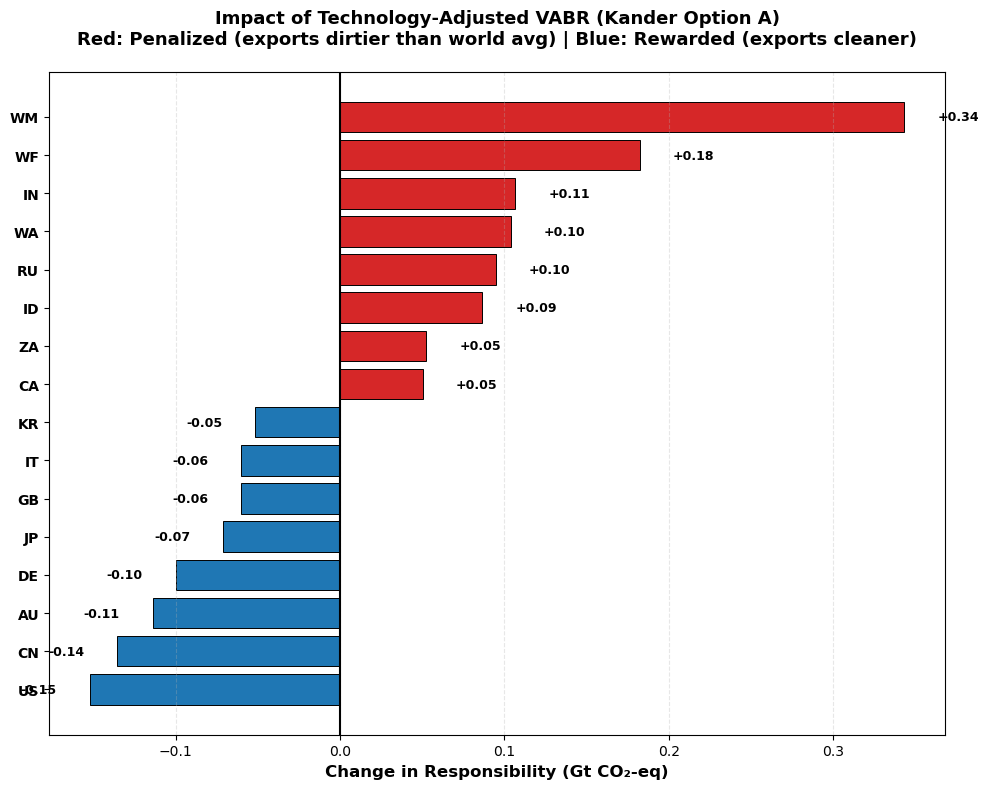


✓ Horizontal bar chart created

=== DISTRIBUTIONAL EFFECT BY COUNTRY GROUP ===

                                        Country Group  Δ Responsibility (Gt CO₂-eq)                                Interpretation
Major emerging exporters (CN, IN, BR, ZA, ID, TR, MX)                          0.11 Penalized (export mix dirtier than world avg)
                                         EU economies                         -0.46         Rewarded (clean, high-tech exporters)
Other advanced exporters (US, JP, CA, AU, KR, NO, CH)                         -0.42                                      Rewarded

Net redistribution: 0.49 Gt from developing to developed

=== TOP 5 PENALIZED AND REWARDED COUNTRIES ===

Penalized Countries  Change (Gt) Rewarded Countries  Change (Gt).1
                 WM         0.34                 JP          -0.07
                 WF         0.18                 DE          -0.10
                 IN         0.11                 AU          -0.11
                 WA     

In [134]:
# ===================================================================
# KANDER OPTION A: SIMPLE VISUALIZATIONS
# ===================================================================

print("\n=== KANDER OPTION A: POLICY-ORIENTED VISUALIZATIONS ===")

# ===================================================================
# 1. HORIZONTAL BAR CHART: Who gains/loses?
# ===================================================================

# Select top 8 penalized and top 8 rewarded
top_penalized = comparison_kander_fixed.nlargest(8, 'Change (Gt)')
top_rewarded = comparison_kander_fixed.nsmallest(8, 'Change (Gt)')

# Combine and sort by change
selected_countries = pd.concat([top_penalized, top_rewarded])
selected_countries = selected_countries.sort_values('Change (Gt)', ascending=True)

# Create horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 8))

# Color: Red for penalized (positive), Blue for rewarded (negative)
colors = ['#d62728' if x > 0 else '#1f77b4' for x in selected_countries['Change (Gt)']]

bars = ax.barh(range(len(selected_countries)), 
               selected_countries['Change (Gt)'],
               color=colors,
               edgecolor='black',
               linewidth=0.7)

# Country labels
ax.set_yticks(range(len(selected_countries)))
ax.set_yticklabels(selected_countries.index, fontsize=10, fontweight='bold')

# Add value labels on bars
for i, (country, value) in enumerate(selected_countries['Change (Gt)'].items()):
    if abs(value) > 0.02:  # Only label significant changes
        x_pos = value + (0.02 if value > 0 else -0.02)
        ha = 'left' if value > 0 else 'right'
        ax.text(x_pos, i, f'{value:+.2f}', 
                va='center', ha=ha, fontsize=9, fontweight='bold')

# Zero line
ax.axvline(0, color='black', linewidth=1.5, linestyle='-')

# Labels and title
ax.set_xlabel('Change in Responsibility (Gt CO₂-eq)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Technology-Adjusted VABR (Kander Option A)\n'
             'Red: Penalized (exports dirtier than world avg) | Blue: Rewarded (exports cleaner)',
             fontsize=13, fontweight='bold', pad=20)

ax.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n✓ Horizontal bar chart created")

# ===================================================================
# 2. AGGREGATE TABLE: Distributional effect by country group
# ===================================================================

print("\n=== DISTRIBUTIONAL EFFECT BY COUNTRY GROUP ===\n")

# Define groups
developing = ['CN', 'IN', 'BR', 'ZA', 'ID', 'TR', 'MX']
developed_eu = ['FR', 'DE', 'IT', 'GB', 'ES', 'SE', 'NL', 'BE', 'AT', 
                'FI', 'DK', 'PT', 'GR', 'IE', 'PL', 'CZ', 'RO', 'HU',
                'BG', 'HR', 'SK', 'SI', 'LT', 'LV', 'EE', 'CY', 'LU', 'MT']
developed_other = ['US', 'JP', 'CA', 'AU', 'KR', 'NO', 'CH']

# Calculate aggregates
dev_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developing), 'Change (Gt)'
].sum()

devd_eu_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_eu), 'Change (Gt)'
].sum()

devd_other_change = comparison_kander_fixed.loc[
    comparison_kander_fixed.index.isin(developed_other), 'Change (Gt)'
].sum()

# Create table
aggregate_table = pd.DataFrame({
    'Country Group': [
        'Major emerging exporters (CN, IN, BR, ZA, ID, TR, MX)',
        'EU economies',
        'Other advanced exporters (US, JP, CA, AU, KR, NO, CH)',
    ],
    'Δ Responsibility (Gt CO₂-eq)': [
        dev_change,
        devd_eu_change,
        devd_other_change
    ],
    'Interpretation': [
        'Penalized (export mix dirtier than world avg)',
        'Rewarded (clean, high-tech exporters)',
        'Rewarded'
    ]
})

print(aggregate_table.to_string(index=False))

# Summary statistics
total_redistribution = abs(dev_change) + abs(devd_eu_change + devd_other_change)
print(f"\nNet redistribution: {total_redistribution/2:.2f} Gt from developing to developed")

# ===================================================================
# 3. SIMPLE SUMMARY TABLE: Top penalized and rewarded
# ===================================================================

print("\n=== TOP 5 PENALIZED AND REWARDED COUNTRIES ===\n")

summary_table = pd.DataFrame({
    'Penalized Countries': top_penalized.nlargest(5, 'Change (Gt)').index.tolist(),
    'Change (Gt)': top_penalized.nlargest(5, 'Change (Gt)')['Change (Gt)'].values,
    'Rewarded Countries': top_rewarded.nsmallest(5, 'Change (Gt)').index.tolist()[::-1],
    'Change (Gt).1': top_rewarded.nsmallest(5, 'Change (Gt)')['Change (Gt)'].values[::-1]
})

print(summary_table.to_string(index=False))

# ===================================================================
# 4. KEY MESSAGES (for your thesis)
# ===================================================================

print("\n" + "="*70)
print("KEY MESSAGES FOR THESIS")
print("="*70)

print("\n1. WHAT OPTION A CORRECTS:")
print("   → Trade-technology correction")
print("   → Exporters with dirtier-than-average sectors: responsibility increases")
print("   → Exporters with cleaner-than-average sectors: responsibility decreases")

print("\n2. WHAT IT DOES NOT CORRECT:")
print("   → TCBA still reallocated via value-added")
print("   → 'Dirty but poor' sectors with low VA remain underweighted")
print("   → Sector-level efficiency bias of VABR still present")

print("\n3. EQUITY IMPLICATION:")
print(f"   → Developing countries: {dev_change:+.2f} Gt (penalized)")
print(f"   → Developed countries: {(devd_eu_change + devd_other_change):+.2f} Gt (rewarded)")
print("   → Shifts burden FROM efficient rich exporters TO developing exporters")
print("   → May CONFLICT with CBDR / capacity-to-pay principles")

print("\n4. CONCLUSION:")
print("   → Consumer-side adjustment (Kander Option A) does NOT solve efficiency bias")
print("   → Actually HARMS equity by penalizing developing country exporters")
print("   → Motivates need for PRODUCER-SIDE approach")

print("\n" + "="*70)

In [ ]:
# ===================================================================
# SMALL ANALYSIS BLOCK FOR OPTION B
# ===================================================================

print("\n=== RUNNING SMALL OPTION B ANALYSIS (world_avg, alpha=1) ===")

resp_B, vabr_base, tech_penalty, gaps = calculate_vabr_with_tech_penalty(
    ixi_data,
    producer_emissions,
    v_clean_all,       # your all-VA coefficients
    benchmark_mode="world_avg",
    alpha=1.0
)

# Comparison DataFrame in Gt
comparison_B = pd.DataFrame({
    "VABR": vabr_base / 1e9,
    "Tech penalty": tech_penalty / 1e9,
    "Total (VABR + tech)": resp_B / 1e9,
})
comparison_B["Change (Gt)"] = comparison_B["Total (VABR + tech)"] - comparison_B["VABR"]
comparison_B["Change (%)"] = comparison_B["Change (Gt)"] / comparison_B["VABR"] * 100

print("\n### TOP 10 COUNTRIES BY TECH PENALTY (Gt) ###")
print(
    comparison_B.nlargest(10, "Tech penalty")[
        ["VABR", "Tech penalty", "Total (VABR + tech)", "Change (%)"]
    ]
)

# Simple bar plot: top 10 penalized countries
top10_penalized = comparison_B.nlargest(10, "Tech penalty").sort_values("Tech penalty")

fig, ax = plt.subplots(figsize=(8, 6))
ax.barh(
    top10_penalized.index,
    top10_penalized["Tech penalty"],
    color="#d62728",
    edgecolor="black",
    linewidth=0.7,
)
ax.set_xlabel("Technology-gap penalty (Gt CO₂-eq)", fontsize=11)
ax.set_title(
    "Top 10 countries by producer-side technology-gap penalty\n"
    "(world-average benchmark, α = 1)",
    fontsize=12,
    fontweight="bold",
)
ax.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Sector-level: top 10 sectors with highest avoidable emissions
sector_totals = (
    gaps.groupby(level=1)["excess_emissions"].sum().sort_values(ascending=False) / 1e9
)

print("\n### TOP 10 SECTORS BY AVOIDABLE EMISSIONS (GLOBAL) ###")
for sector, value in sector_totals.head(10).items():
    print(f"{sector[:60]:60s}  {value:6.3f} Gt")



=== PLOT: VABR vs. VABR + Technology Penalty (Option B) ===


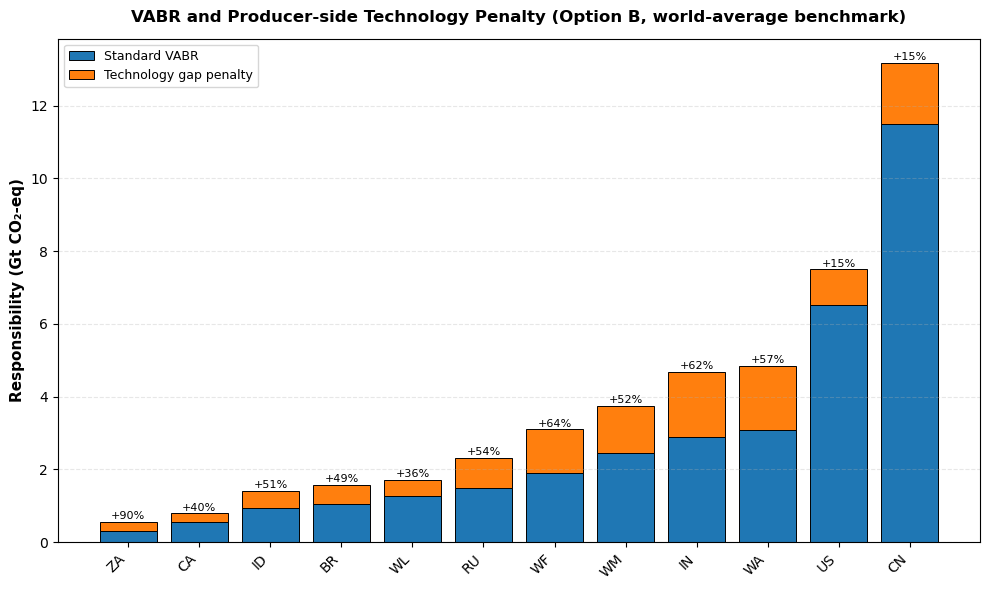

✓ Stacked bar chart created (Standard VABR + Tech penalty).


In [130]:
# ===================================================================
# STACKED BAR: STANDARD VABR + TECH PENALTY (OPTION B)
# ===================================================================

print("\n=== PLOT: VABR vs. VABR + Technology Penalty (Option B) ===")

# Falls du vorher schon comparison_B definiert hast, kannst du es recyclen,
# aber hier baue ich eine saubere comparison_tech_penalty-Table neu:

comparison_tech_penalty = pd.DataFrame({
    "Standard VABR": vabr_base / 1e9,          # Gt
    "Tech Penalty": tech_penalty / 1e9,        # Gt
    "Total (VABR + Tech)": resp_B / 1e9,       # Gt
})

# Optional: zusätzlich Change-Spalten
comparison_tech_penalty["Change (Gt)"] = (
    comparison_tech_penalty["Total (VABR + Tech)"] 
    - comparison_tech_penalty["Standard VABR"]
)
comparison_tech_penalty["Change (%)"] = (
    comparison_tech_penalty["Change (Gt)"] 
    / comparison_tech_penalty["Standard VABR"].replace(0, np.nan) 
    * 100
)

# Wieviele Länder anzeigen?
TOP_N = 12

# Top penalized Länder auswählen
plot_df = comparison_tech_penalty.nlargest(TOP_N, "Tech Penalty")[
    ["Standard VABR", "Tech Penalty", "Total (VABR + Tech)"]
].copy()

# Für schöne Plot-Reihenfolge nach totaler Verantwortung sortieren
plot_df = plot_df.sort_values("Total (VABR + Tech)", ascending=True)

# X-Position explizit definieren (verhindert Ärger mit String-Indizes)
x = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(10, 6))

# Basis: Standard VABR
ax.bar(
    x,
    plot_df["Standard VABR"],
    label="Standard VABR",
    color="#1f77b4",
    edgecolor="black",
    linewidth=0.7
)

# Oben drauf: Tech penalty
ax.bar(
    x,
    plot_df["Tech Penalty"],
    bottom=plot_df["Standard VABR"],
    label="Technology gap penalty",
    color="#ff7f0e",
    edgecolor="black",
    linewidth=0.7
)

# Achsenlabel & Titel
ax.set_ylabel("Responsibility (Gt CO₂-eq)", fontsize=11, fontweight="bold")
ax.set_title(
    "VABR and Producer-side Technology Penalty (Option B, world-average benchmark)",
    fontsize=12,
    fontweight="bold",
    pad=12
)

# X-Achse: Länderlabels
ax.set_xticks(x)
ax.set_xticklabels(plot_df.index, rotation=45, ha="right")

# Grid
ax.grid(axis="y", alpha=0.3, linestyle="--")

# Legende
ax.legend(fontsize=9, loc="upper left")

# Optionale Prozent-Annotationen
for i, (country, row) in enumerate(plot_df.iterrows()):
    total = row["Total (VABR + Tech)"]
    if row["Standard VABR"] > 0:
        change_pct = (row["Tech Penalty"] / row["Standard VABR"]) * 100
    else:
        change_pct = 0.0
    ax.text(
        i,
        total + 0.02,  # etwas über dem gestapelten Balken
        f"+{change_pct:.0f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

print("✓ Stacked bar chart created (Standard VABR + Tech penalty).")
